<a href="https://colab.research.google.com/github/juhungaro/Pipoca/blob/main/Entrega2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Etapa 1 ‚Äì Pr√©-processamento dos Dados

*   Organizar os datasets de imagens e dados temporais coletados na Sprint 1.
*   Realizar tratamento dos dados, garantindo que estejam estruturados e prontos para serem usados no modelo.
*   Identificar padr√µes e sazonalidades na s√©rie temporal NDVI, explorando diferentes abordagens estat√≠sticas para entender varia√ß√µes de produtividade.

# Dados SatVeg

Dados obtidos do sensor SatVeg para a Fazenda S√£o Jos√©, Sorriso-MT
Coordenadas: -55.95520,-12.88229 | -55.95729,-12.88229

Bibliotecas necess√°rias

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

Upload dos dados

In [35]:
# 1. Carregamento importa√ß√£o de dados
print("1. Carregamento dos dados do SatVeg")
from google.colab import files
uploaded = files.upload()

# Carregar o arquivo CSV
filename = list(uploaded.keys())[0]
df_satveg = pd.read_csv(filename, encoding='latin1', sep=';')

# Informa√ß√µes b√°sicas
print(f"Arquivo carregado: {filename}")
print(f"Dimens√µes: {df_satveg.shape[0]} linhas x {df_satveg.shape[1]} colunas")


1. Carregamento dos dados do SatVeg


Saving dados_satveg.csv to dados_satveg.csv
Arquivo carregado: dados_satveg.csv
Dimens√µes: 576 linhas x 4 colunas


In [43]:
## 2. Pr√©-processamento
print("\n2. Pr√©-processamento dos dados")

# Converter colunas data
if 'Data' in df_satveg.columns:
    df_satveg['Data'] = pd.to_datetime(df_satveg['Data'], format='%d/%m/%Y', errors='coerce')
    print("- Coluna 'Data' convertida para datetime")

# Criando colunas auxiliares
df_satveg['mes'] = df_satveg['Data'].dt.month
df_satveg['ano'] = df_satveg['Data'].dt.year

# Converter colunas num√©ricas
colunas_numericas = ["NDVI", "PreFiltro", "FlatBottom"]
print("- Convertendo colunas num√©ricas:")

for coluna in colunas_numericas:
    if coluna in df_satveg.columns:
        # Guardar tipo original para mostrar a mudan√ßa
        tipo_original = df_satveg[coluna].dtype

        # Converter de string com v√≠rgula para float
        if df_satveg[coluna].dtype == 'object':
            df_satveg[coluna] = df_satveg[coluna].str.replace(',', '.').astype(float)
            print(f"  Coluna '{coluna}' convertida: {tipo_original} ‚Üí {df_satveg[coluna].dtype}")
        else:
            print(f"  Coluna '{coluna}' j√° √© do tipo num√©rico: {df_satveg[coluna].dtype}")
    else:
        print(f"  Aten√ß√£o: Coluna '{coluna}' n√£o encontrada no DataFrame")

# Verificar valores nulos
nulos = df_satveg.isnull().sum()
print("- Valores nulos por coluna:")
print(nulos[nulos > 0] if any(nulos > 0) else "  N√£o h√° valores nulos")


2. Pr√©-processamento dos dados
- Coluna 'Data' convertida para datetime
- Convertendo colunas num√©ricas:
  Coluna 'NDVI' j√° √© do tipo num√©rico: float64
  Coluna 'PreFiltro' j√° √© do tipo num√©rico: float64
  Coluna 'FlatBottom' j√° √© do tipo num√©rico: float64
- Valores nulos por coluna:
  N√£o h√° valores nulos


In [44]:
df_satveg.head()

Data    NDVI  PreFiltro  FlatBottom   AnoMes  NDVI_media_mensal  mes  \
0 2000-02-18  0.6119     0.6542      0.6542  2000-02            0.61190    2   
1 2000-03-05  0.6542     0.6542      0.6542  2000-03            0.61465    3   
2 2000-03-21  0.5751     0.5751      0.6542  2000-03            0.61465    3   
3 2000-04-06  0.6839     0.6839      0.6839  2000-04            0.58180    4   
4 2000-04-22  0.4797     0.4797      0.4808  2000-04            0.58180    4   

    ano  
0  2000  
1  2000  
2  2000  
3  2000  
4  2000

In [38]:
# Garante que 'Data' est√° como datetime
df_satveg['Data'] = pd.to_datetime(df_satveg['Data'], errors='coerce')

# Cria a coluna 'AnoMes' no formato 'YYYY-MM'
df_satveg['AnoMes'] = df_satveg['Data'].dt.to_period('M').astype(str)

if 'NDVI' in df_satveg.columns and 'AnoMes' in df_satveg.columns:
    # Para cada m√™s, calcula a m√©dia e atribui a todas as linhas daquele m√™s
    df_satveg['NDVI_media_mensal'] = df_satveg.groupby('AnoMes')['NDVI'].transform('mean')
    print("\nColuna 'NDVI_media_mensal' adicionada ao DataFrame!")
    print(df_satveg[['Data', 'NDVI', 'AnoMes', 'NDVI_media_mensal']].head())
else:
    print("\nN√£o foi poss√≠vel criar a m√©dia mensal do NDVI: Colunas necess√°rias n√£o encontradas.")





Coluna 'NDVI_media_mensal' adicionada ao DataFrame!
        Data    NDVI   AnoMes  NDVI_media_mensal
0 2000-02-18  0.6119  2000-02            0.61190
1 2000-03-05  0.6542  2000-03            0.61465
2 2000-03-21  0.5751  2000-03            0.61465
3 2000-04-06  0.6839  2000-04            0.58180
4 2000-04-22  0.4797  2000-04            0.58180


In [39]:
## 3. An√°lise Explorat√≥ria B√°sica
print("\n3. An√°lise Explorat√≥ria B√°sica")
print("- Primeiras linhas dos dados:")
display(df_satveg.head())

print("\n- Resumo estat√≠stico das colunas num√©ricas:")
display(df_satveg[colunas_numericas].describe())


3. An√°lise Explorat√≥ria B√°sica
- Primeiras linhas dos dados:


Data    NDVI  PreFiltro  FlatBottom   AnoMes  NDVI_media_mensal
0 2000-02-18  0.6119     0.6542      0.6542  2000-02            0.61190
1 2000-03-05  0.6542     0.6542      0.6542  2000-03            0.61465
2 2000-03-21  0.5751     0.5751      0.6542  2000-03            0.61465
3 2000-04-06  0.6839     0.6839      0.6839  2000-04            0.58180
4 2000-04-22  0.4797     0.4797      0.4808  2000-04            0.58180


- Resumo estat√≠stico das colunas num√©ricas:


NDVI   PreFiltro  FlatBottom
count  576.000000  576.000000  576.000000
mean     0.438249    0.470147    0.478435
std      0.185401    0.178731    0.176696
min     -0.300000    0.158200    0.187300
25%      0.291450    0.307225    0.310100
50%      0.391100    0.447650    0.468250
75%      0.590000    0.624850    0.629725
max      0.871500    0.871500    0.871500


4. Visualiza√ß√£o de Dados
 Histograma - Distribui√ß√£o das vari√°veis:


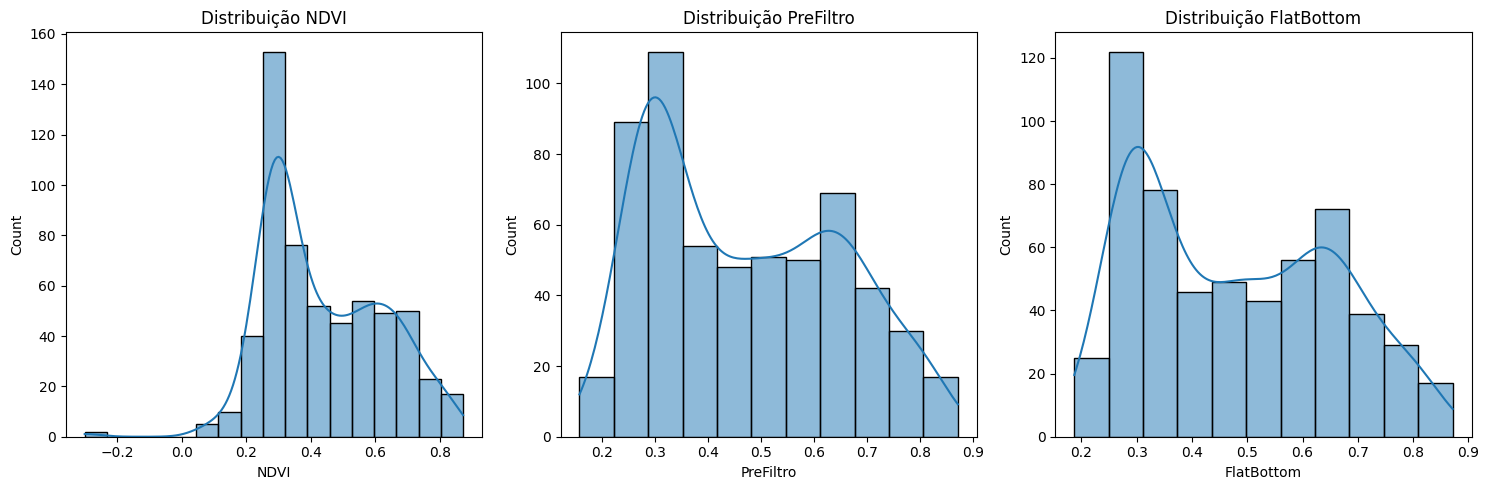

In [ ]:
## Visualiza√ß√£o de Dados
print("\n4. Visualiza√ß√£o de Dados")

# 4.1 Distribui√ß√µes (histogramas)
print(" Histograma - Distribui√ß√£o das vari√°veis:")
plt.figure(figsize=(15, 5))

for i, coluna in enumerate(colunas_numericas):
    plt.subplot(1, 3, i+1)
    sns.histplot(df_satveg[coluna], kde=True)
    plt.title(f'Distribui√ß√£o {coluna}')

plt.tight_layout()
plt.show()

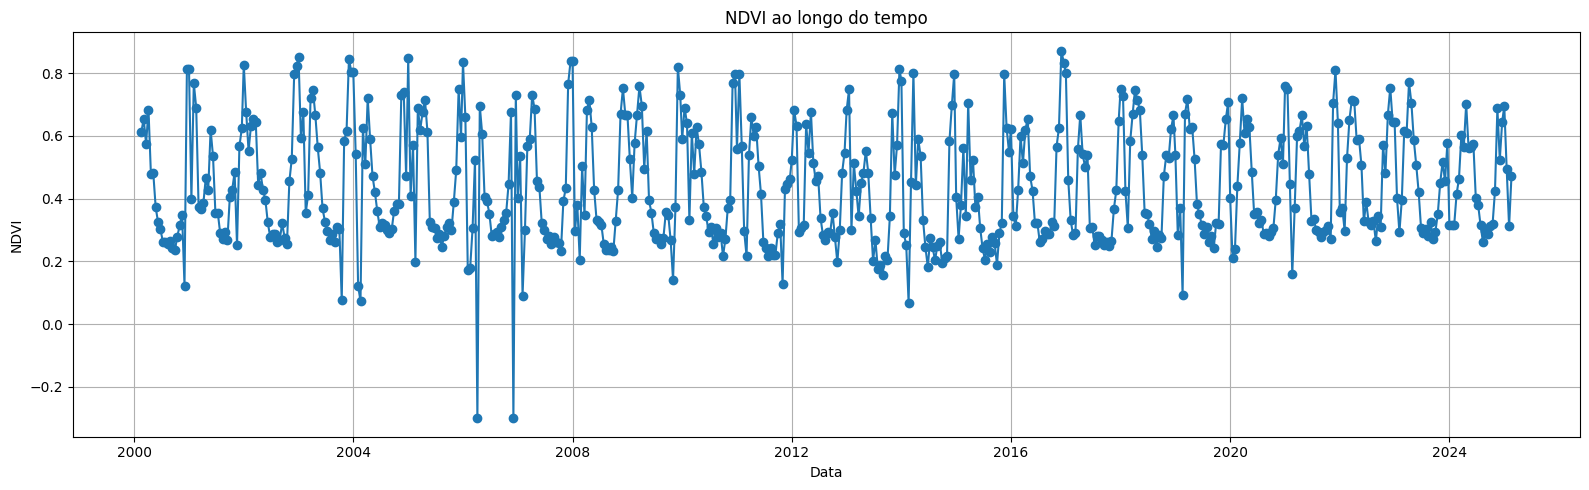

In [45]:
# Serie temporal completa
plt.figure(figsize=(16,5))
plt.plot(df_satveg['Data'], df_satveg['NDVI'], marker='o', linestyle='-')
plt.title('NDVI ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('NDVI')
plt.grid(True)
plt.tight_layout()
plt.show()


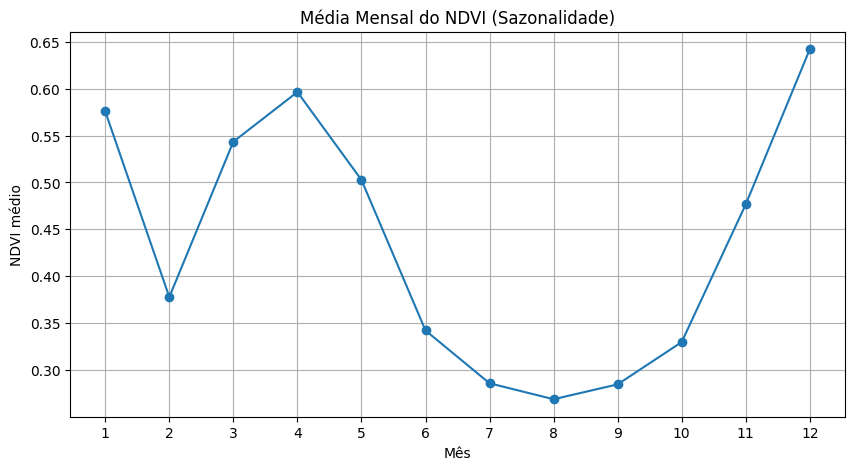

In [47]:
# Gr√°fico da m√©dia mensal (sazonalidade t√≠pica)
ndvi_media_mensal = df_satveg.groupby('mes')['NDVI'].mean()

plt.figure(figsize=(10,5))
plt.plot(ndvi_media_mensal.index, ndvi_media_mensal.values, marker='o')
plt.title('M√©dia Mensal do NDVI (Sazonalidade)')
plt.xlabel('M√™s')
plt.ylabel('NDVI m√©dio')
plt.xticks(range(1,13))
plt.grid(True)
plt.show()


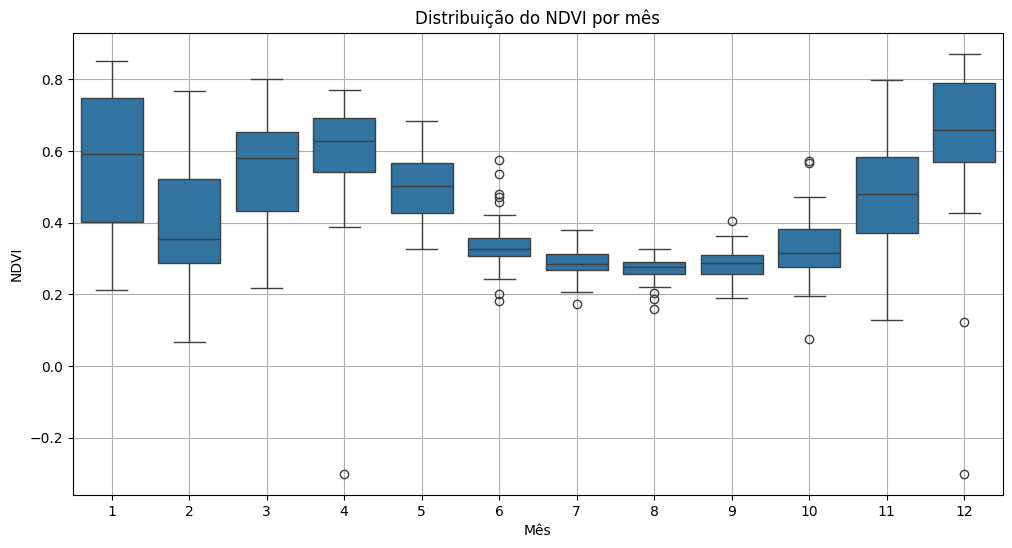

In [48]:
# Boxplot do NDVI por m√™s
plt.figure(figsize=(12,6))
sns.boxplot(x='mes', y='NDVI', data=df_satveg)
plt.title('Distribui√ß√£o do NDVI por m√™s')
plt.xlabel('M√™s')
plt.ylabel('NDVI')
plt.grid(True)
plt.show()


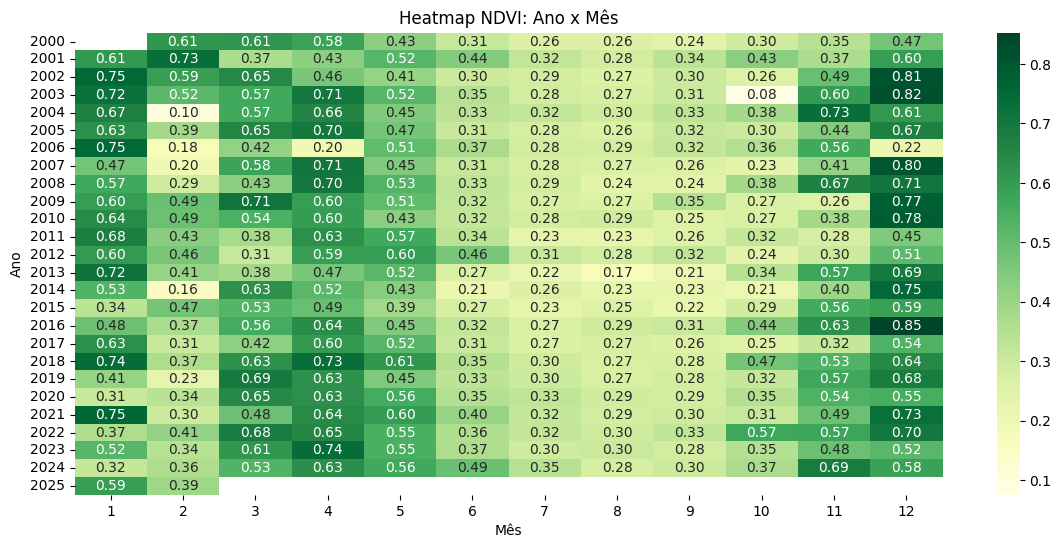

In [50]:
# Heatmap Ano vs M√™s do NDVI
pivot = df_satveg.pivot_table(
    index='ano', columns='mes', values='NDVI', aggfunc='mean'
)

plt.figure(figsize=(14,6))
sns.heatmap(pivot, cmap='YlGn', annot=True, fmt=".2f")
plt.title('Heatmap NDVI: Ano x M√™s')
plt.xlabel('M√™s')
plt.ylabel('Ano')
plt.show()


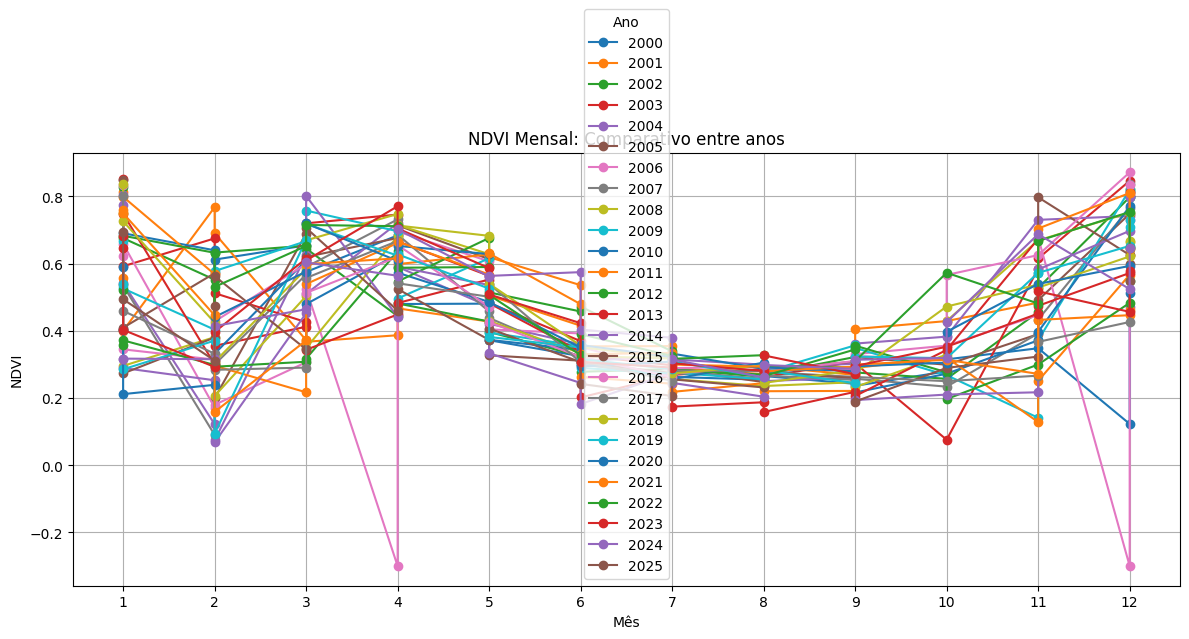

In [51]:
#Gr√°fico de linhas sobrepostas por ano
plt.figure(figsize=(12,6))
for ano, grupo in df_satveg.groupby('ano'):
    plt.plot(grupo['mes'], grupo['NDVI'], marker='o', label=ano)

plt.title('NDVI Mensal: Comparativo entre anos')
plt.xlabel('M√™s')
plt.ylabel('NDVI')
plt.xticks(range(1, 13))
plt.legend(title="Ano")
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-52-e04628ba0c5f>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ndvi_monthly = df_satveg.set_index('Data')['NDVI'].resample('M').mean().interpolate()


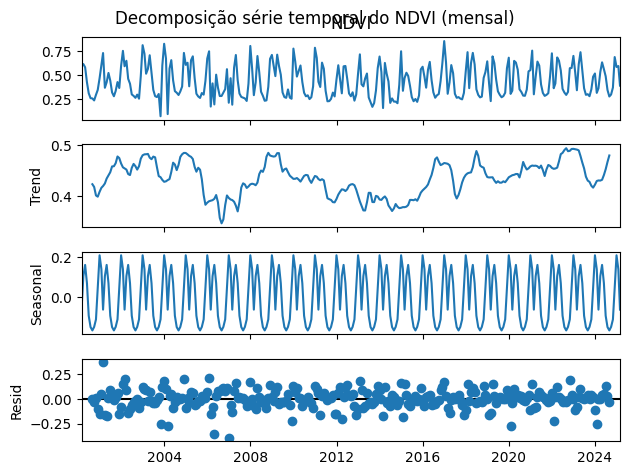

In [52]:
# Decomposi√ß√£o da s√©rie temporal (tend√™ncia + sazonalidade)

# Dados reagrupados mensalmente
ndvi_monthly = df_satveg.set_index('Data')['NDVI'].resample('M').mean().interpolate()

decomp = seasonal_decompose(ndvi_monthly, model='additive', period=12)
decomp.plot()
plt.suptitle('Decomposi√ß√£o s√©rie temporal do NDVI (mensal)')
plt.show()



 Dispers√£o - Rela√ß√µes entre vari√°veis:


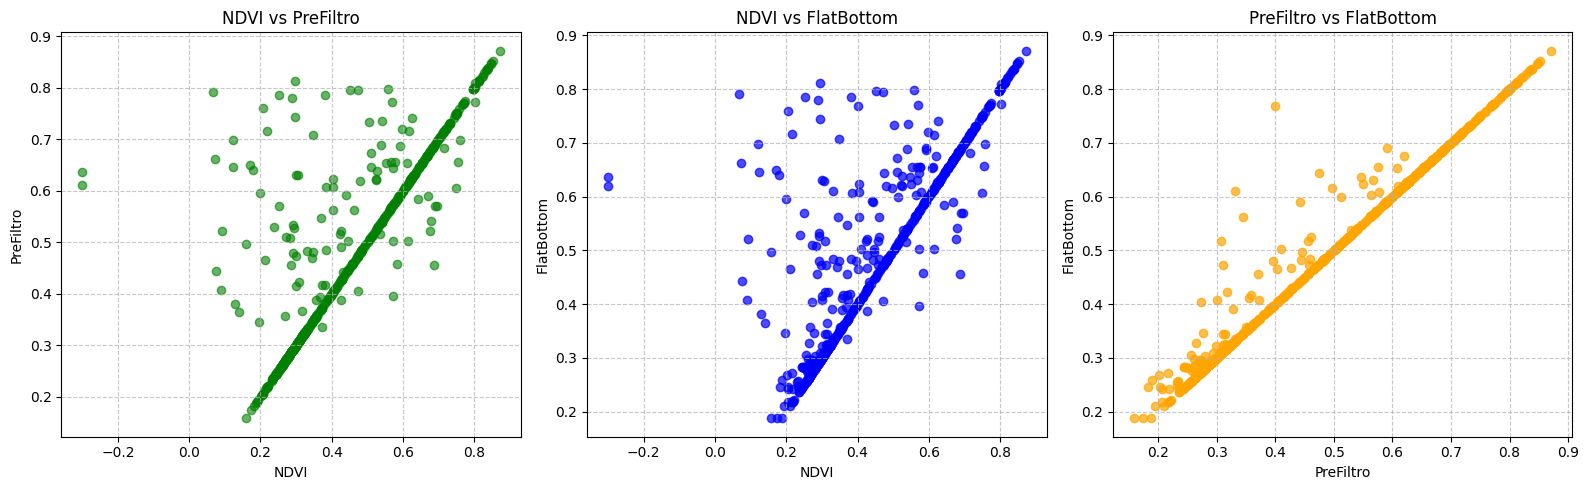

In [ ]:
# 4.3 Rela√ß√µes entre vari√°veis (dispers√£o)
print("\n Dispers√£o - Rela√ß√µes entre vari√°veis:")
plt.figure(figsize=(16, 5))

# Gr√°fico 1: NDVI vs PreFiltro
plt.subplot(1, 3, 1)
plt.scatter(df_satveg['NDVI'], df_satveg['PreFiltro'], alpha=0.6, color='green' )
plt.title('NDVI vs PreFiltro')
plt.xlabel('NDVI')
plt.ylabel('PreFiltro')
plt.grid(True, linestyle='--', alpha=0.7)

# Gr√°fico 2: NDVI vs FlatBottom
plt.subplot(1, 3, 2)
plt.scatter(df_satveg['NDVI'], df_satveg['FlatBottom'], alpha=0.7, color='blue')
plt.title('NDVI vs FlatBottom')
plt.xlabel('NDVI')
plt.ylabel('FlatBottom')
plt.grid(True, linestyle='--', alpha=0.7)

# Gr√°fico 3: PreFiltro vs FlatBottom
plt.subplot(1, 3, 3)
plt.scatter(df_satveg['PreFiltro'], df_satveg['FlatBottom'], alpha=0.7, color='orange')
plt.title('PreFiltro vs FlatBottom')
plt.xlabel('PreFiltro')
plt.ylabel('FlatBottom')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


 Boxplots - Compara√ß√£o de distribui√ß√£o entre vari√°veis:


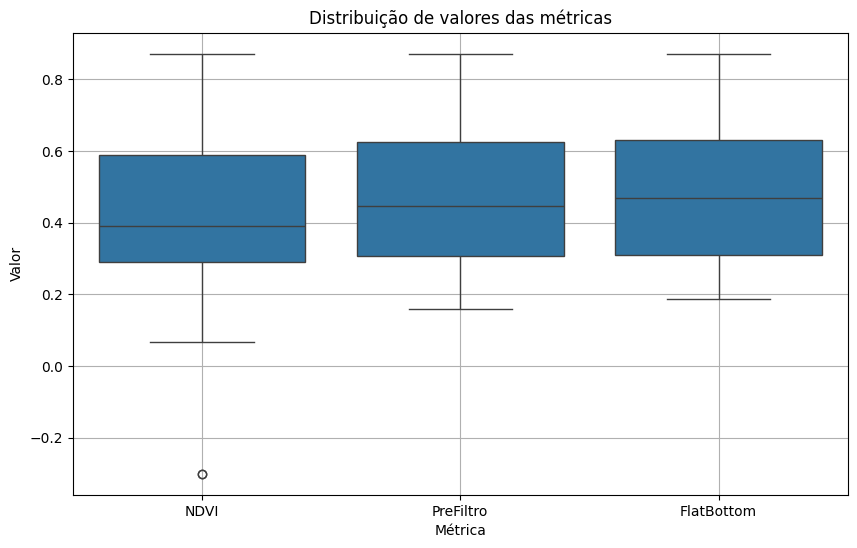

In [ ]:
# 4.4 Compara√ß√£o de vari√°veis (boxplots)
print("\n Boxplots - Compara√ß√£o de distribui√ß√£o entre vari√°veis:")
plt.figure(figsize=(10, 6))
df_melt = df_satveg.melt(id_vars='Data', value_vars=colunas_numericas,
                  var_name='M√©trica', value_name='Valor')
sns.boxplot(x='M√©trica', y='Valor', data=df_melt)
plt.title('Distribui√ß√£o de valores das m√©tricas')
plt.grid(True)
plt.show()


 Matriz de correla√ß√£o entre as m√©tricas:


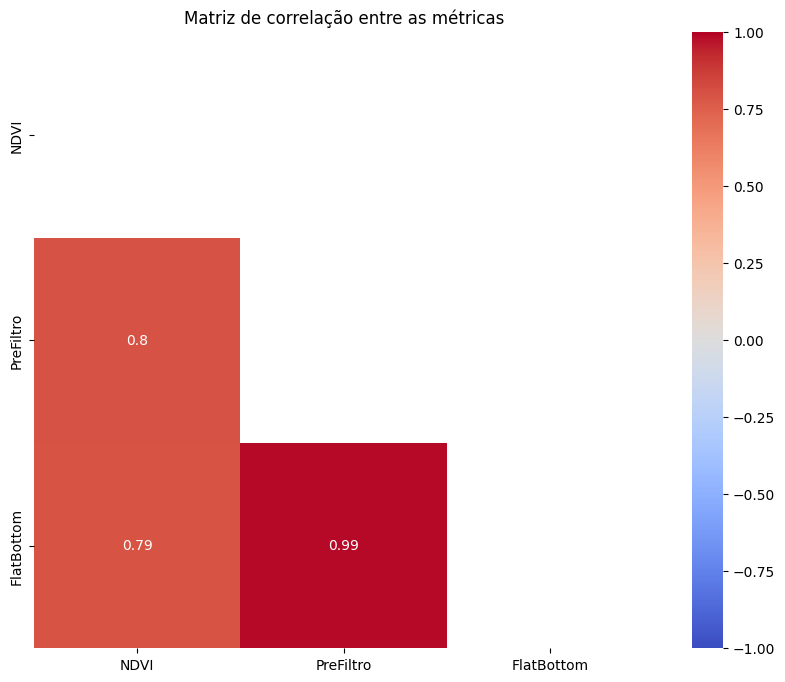

In [ ]:
# 4.5 Matriz de correla√ß√£o
print("\n Matriz de correla√ß√£o entre as m√©tricas:")
plt.figure(figsize=(10, 8))
corr = df_satveg[colunas_numericas].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, cmap='coolwarm', mask=mask, vmin=-1, vmax=1)
plt.title('Matriz de correla√ß√£o entre as m√©tricas')
plt.show()



In [55]:
## 5. Exporta√ß√£o dos dados processados
print("\n5. Exporta√ß√£o dos dados processados")
df_satveg.to_csv('satveg_processado.csv', index=False)
print("- Dados processados salvos como 'satveg_processado.csv'")


5. Exporta√ß√£o dos dados processados
- Dados processados salvos como 'satveg_processado.csv'


# Dados metereol√≥gicos INMET
Optamos por fazer download dos arquivos, pois via API ia ficar muito lento

Fonte de dados https://portal.inmet.gov.br/dadoshistoricos

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob

In [59]:
from google.colab import files
uploaded = files.upload()

Saving Clima_Sorriso_2018.csv to Clima_Sorriso_2018.csv
Saving Clima_Sorriso_2019.csv to Clima_Sorriso_2019.csv
Saving Clima_Sorriso_2025.csv to Clima_Sorriso_2025.csv
Saving Clima_Sorriso_2024.csv to Clima_Sorriso_2024.csv
Saving Clima_Sorriso_2023.csv to Clima_Sorriso_2023.csv
Saving Clima_Sorriso_2020.csv to Clima_Sorriso_2020.csv
Saving Clima_Sorriso_2017.csv to Clima_Sorriso_2017.csv
Saving Clima_Sorriso_2016.csv to Clima_Sorriso_2016.csv
Saving Clima_Sorriso_2015.csv to Clima_Sorriso_2015.csv


In [62]:
# Padr√£o dos arquivos: Clima_Sorriso_*.csv
arquivos = sorted(glob.glob('Clima_Sorriso_*.csv'))  # lista todos os arquivos que batem com o padr√£o

print("Arquivos encontrados:", arquivos)

# L√™ todos os arquivos e empilha tudo em um s√≥ DataFrame
dfs = []
for arq in arquivos:
    print("Lendo:", arq)
    df_temp = pd.read_csv(arq, sep=";", encoding='latin1')
    dfs.append(df_temp)

# Junta tudo em um DataFrame s√≥
df_climatotal = pd.concat(dfs, ignore_index=True)

df_climatotal['DATA'] = pd.to_datetime(df_climatotal['DATA'], errors='coerce')

# Visualiza primeiras linhas da base consolidada
print("\nBase consolidada, preview:")
print(df_climatotal.head())
print(f"\nTotal de linhas lidas: {df_climatotal.shape[0]}")


Arquivos encontrados: ['Clima_Sorriso_2015.csv', 'Clima_Sorriso_2016.csv', 'Clima_Sorriso_2017.csv', 'Clima_Sorriso_2018.csv', 'Clima_Sorriso_2019.csv', 'Clima_Sorriso_2020.csv', 'Clima_Sorriso_2023.csv', 'Clima_Sorriso_2024.csv', 'Clima_Sorriso_2025.csv']
Lendo: Clima_Sorriso_2015.csv
Lendo: Clima_Sorriso_2016.csv
Lendo: Clima_Sorriso_2017.csv
Lendo: Clima_Sorriso_2018.csv
Lendo: Clima_Sorriso_2019.csv
Lendo: Clima_Sorriso_2020.csv
Lendo: Clima_Sorriso_2023.csv
Lendo: Clima_Sorriso_2024.csv
Lendo: Clima_Sorriso_2025.csv

Base consolidada, preview:
        DATA   HORA  RADIACAO  TEMPERATURA  RADIACA
0 2015-01-01  00:00   -9999.0         23.0      NaN
1 2015-01-01  01:00   -9999.0         23.1      NaN
2 2015-01-01  02:00   -9999.0         22.9      NaN
3 2015-01-01  03:00   -9999.0         22.7      NaN
4 2015-01-01  04:00   -9999.0         22.4      NaN

Total de linhas lidas: 72312


Tratamento dos dados

In [63]:
# Validar os periodos do dataframe
df_climatotal['DATA'] = pd.to_datetime(df_climatotal['DATA'], format='%d/%m/%Y')

# 2. Encontrar a menor e maior data:
menor_data = df_climatotal['DATA'].min()
maior_data = df_climatotal['DATA'].max()

# 3. Mostrar
print("Menor data:", menor_data.strftime('%d/%m/%Y'))
print("Maior data:", maior_data.strftime('%d/%m/%Y'))

df_climatotal['RADIACAO'] = df_climatotal['RADIACAO'].replace(-9999, np.nan)
df_climatotal['TEMPERATURA'] = df_climatotal['TEMPERATURA'].replace(-9999, np.nan)


Menor data: 01/01/2015
Maior data: 03/12/2025


In [64]:
# Optamos por salvar o dataset unificado para facilitar o trabalho
df_climatotal.to_csv('clima_consolidados.csv', index=False)
print("Arquivo 'clima_consolidados.csv' salvo!")


Arquivo 'clima_consolidados.csv' salvo!


In [65]:
# Valida√ß√£o do dataset consolidado
# Tamanho do dataset
print(f"Linhas: {df_climatotal.shape[0]}, Colunas: {df_climatotal.shape[1]}")

# Mostrar os primeiros registros
display(df_climatotal.head(10))

# Informa√ß√µes gerais das colunas
df_climatotal.info()

# Checar as primeiras datas (caso ainda precise revisar datas)
print("Menor data:", df_climatotal['DATA'].min())
print("Maior data:", df_climatotal['DATA'].max())


Linhas: 72312, Colunas: 5


DATA   HORA  RADIACAO  TEMPERATURA  RADIACA
0 2015-01-01  00:00       NaN         23.0      NaN
1 2015-01-01  01:00       NaN         23.1      NaN
2 2015-01-01  02:00       NaN         22.9      NaN
3 2015-01-01  03:00       NaN         22.7      NaN
4 2015-01-01  04:00       NaN         22.4      NaN
5 2015-01-01  05:00       NaN         22.4      NaN
6 2015-01-01  06:00       NaN         22.1      NaN
7 2015-01-01  07:00       NaN         22.0      NaN
8 2015-01-01  08:00       NaN         21.9      NaN
9 2015-01-01  09:00       NaN         21.8      NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72312 entries, 0 to 72311
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATA         28512 non-null  datetime64[ns]
 1   HORA         72312 non-null  object        
 2   RADIACAO     31642 non-null  float64       
 3   TEMPERATURA  67273 non-null  float64       
 4   RADIACA      8760 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 2.8+ MB
Menor data: 2015-01-01 00:00:00
Maior data: 2025-12-03 00:00:00


In [66]:
# Remover a coluna 'RADIACA' permanentemente do DataFrame
df_climatotal = df_climatotal.drop('RADIACA', axis=1)


In [67]:
df_climatotal.loc[df_climatotal['RADIACAO'] < 0, 'RADIACAO'] = np.nan


In [91]:
# Criando a coluna ANO_MES
df_climatotal['ANO_MES'] = df_climatotal['DATA'].dt.strftime('%Y-%m')


df_climatotal['DATA'] = pd.to_datetime(df_climatotal['DATA'], errors='coerce')
df_climatotal['ANO'] = df_climatotal['DATA'].dt.year.astype('Int64')
df_climatotal['MES'] = df_climatotal['DATA'].dt.month.astype('Int64')


print(df_climatotal[['DATA', 'ANO', 'MES', 'ANO_MES', 'RADIACAO', 'TEMPERATURA']].head())

        DATA   ANO  MES  ANO_MES  RADIACAO  TEMPERATURA
0 2015-01-01  2015    1  2015-01       NaN         23.0
1 2015-01-01  2015    1  2015-01       NaN         23.1
2 2015-01-01  2015    1  2015-01       NaN         22.9
3 2015-01-01  2015    1  2015-01       NaN         22.7
4 2015-01-01  2015    1  2015-01       NaN         22.4


In [92]:
#An√°lise de valores nulos, duplicados e convers√£o de tipo de coluna

# Nulos por coluna
print("\nValores nulos por coluna:")
print(df_climatotal.isnull().sum())

# % de nulos para priorizar tratamento
print("\nPorcentagem de nulos:")
print(df_climatotal.isnull().mean().sort_values(ascending=False)*100)

# Linhas duplicadas
print("\nQtde de linhas duplicadas:", df_climatotal.duplicated().sum())

print(df_climatotal.dtypes)




Valores nulos por coluna:
DATA           43800
HORA               0
RADIACAO       40670
TEMPERATURA     5039
ANO_MES        43800
ANO            43800
MES            43800
dtype: int64

Porcentagem de nulos:
DATA           60.570860
ANO            60.570860
ANO_MES        60.570860
MES            60.570860
RADIACAO       56.242394
TEMPERATURA     6.968415
HORA            0.000000
dtype: float64

Qtde de linhas duplicadas: 20536
DATA           datetime64[ns]
HORA                   object
RADIACAO              float64
TEMPERATURA           float64
ANO_MES                object
ANO                     Int64
MES                     Int64
dtype: object


An√°lise explorat√≥ria

In [93]:
print(df_climatotal.describe())


                                DATA      RADIACAO   TEMPERATURA          ANO  \
count                          28512  31642.000000  67273.000000      28512.0   
mean   2019-08-27 14:10:54.545454592   1353.785001     25.312555  2019.181818   
min              2015-01-01 00:00:00      0.000000      3.800000       2015.0   
25%              2017-01-09 18:00:00    363.625000     22.300000       2017.0   
50%              2019-02-06 12:00:00   1285.500000     24.500000       2019.0   
75%              2023-03-03 06:00:00   2269.900000     28.700000       2023.0   
max              2025-12-03 00:00:00   4127.700000     39.400000       2025.0   
std                              NaN   1025.969413      4.893521     3.128173   

            MES  
count   28512.0  
mean        6.5  
min         1.0  
25%        3.75  
50%         6.5  
75%        9.25  
max        12.0  
std    3.452113  


Percebemos que a radia√ß√£o global esta muito alta

In [75]:
print('RADIACAO ‚Üí m√≠nimo:', df_climatotal['RADIACAO'].min(), 'm√°ximo:', df_climatotal['RADIACAO'].max())
print('TEMPERATURA ‚Üí m√≠nimo:', df_climatotal['TEMPERATURA'].min(), 'm√°ximo:', df_climatotal['TEMPERATURA'].max())
print('Primeiros 10 valores de RADIACAO:', df_climatotal['RADIACAO'].head(10).values)
print('Primeiros 10 valores de TEMPERATURA:', df_climatotal['TEMPERATURA'].head(10).values)


RADIACAO ‚Üí m√≠nimo: 0.0 m√°ximo: 4127.7
TEMPERATURA ‚Üí m√≠nimo: 3.8 m√°ximo: 39.4
Primeiros 10 valores de RADIACAO: [nan nan nan nan nan nan nan nan nan nan]
Primeiros 10 valores de TEMPERATURA: [23.  23.1 22.9 22.7 22.4 22.4 22.1 22.  21.9 21.8]


In [76]:
media = df_climatotal['RADIACAO'].mean()
std = df_climatotal['RADIACAO'].std()
print(f"M√©dia: {media:.2f}")
print(f"Desvio padr√£o: {std:.2f}")




M√©dia: 1353.79
Desvio padr√£o: 1025.97


In [77]:
limite_superior = media + 3*std
limite_inferior = media - 3*std

outliers = df_climatotal[(df_climatotal['RADIACAO'] > limite_superior) | (df_climatotal['RADIACAO'] < limite_inferior)]

print("Valores excessivos de RADIA√á√ÉO (outliers >3œÉ):")
print(outliers[['DATA', 'RADIACAO']])


Valores excessivos de RADIA√á√ÉO (outliers >3œÉ):
Empty DataFrame
Columns: [DATA, RADIACAO]
Index: []


In [78]:
print("10 maiores valores:")
print(df_climatotal[['DATA', 'RADIACAO']].sort_values('RADIACAO', ascending=False).head(10))

print("10 menores valores (diferentes de zero/nan):")
print(df_climatotal[['DATA', 'RADIACAO']][df_climatotal['RADIACAO'] > 0].sort_values('RADIACAO', ascending=True).head(10))


10 maiores valores:
            DATA  RADIACAO
53489 2023-06-02    4127.7
71008 2025-05-02    4046.0
27400        NaT    3917.7
9065         NaT    3878.1
36065 2019-11-02    3837.8
44537        NaT    3823.3
8369         NaT    3814.7
7528  2015-10-11    3812.3
35609        NaT    3811.1
42328        NaT    3808.7
10 menores valores (diferentes de zero/nan):
            DATA  RADIACAO
54226 2023-09-03       0.1
62615        NaT       0.1
63459        NaT       0.1
62575        NaT       0.1
17068 2016-12-12       0.1
61824        NaT       0.1
62111        NaT       0.1
34519 2018-09-12       0.1
44927        NaT       0.1
44360        NaT       0.1


In [79]:
media = df_climatotal['RADIACAO'].mean()
std = df_climatotal['RADIACAO'].std()
limite_superior = media + 3*std
limite_inferior = media - 3*std


In [40]:
df_sem_outliers = df_climatotal[(df_climatotal['RADIACAO'] <= limite_superior) & (df_climatotal['RADIACAO'] >= limite_inferior)]


In [41]:
print('Original:', len(df_climatotal), 'Registros ap√≥s excluir outliers:', len(df_sem_outliers))


Original: 72312 Registros ap√≥s excluir outliers: 31642


In [80]:
df_climatotal = df_climatotal.reset_index(drop=True)


In [43]:
print(df_climatotal.describe())

                                DATA      RADIACAO   TEMPERATURA  \
count                          72312  31642.000000  67273.000000   
mean   2019-09-01 21:57:10.335214080   1353.785001     25.312555   
min              2015-01-01 00:00:00      0.000000      3.800000   
25%              2017-01-23 00:00:00    363.625000     22.300000   
50%              2019-02-15 00:00:00   1285.500000     24.500000   
75%              2023-03-09 00:00:00   2269.900000     28.700000   
max              2025-03-31 00:00:00   4127.700000     39.400000   
std                              NaN   1025.969413      4.893521   

                ANO           MES  
count  72312.000000  72312.000000  
mean    2019.180219      6.386326  
min     2015.000000      1.000000  
25%     2017.000000      3.000000  
50%     2019.000000      6.000000  
75%     2023.000000      9.000000  
max     2025.000000     12.000000  
std        3.126790      3.486298  


In [81]:
print("10 maiores valores:")
print(df_climatotal[['DATA', 'RADIACAO']].sort_values('RADIACAO', ascending=False).head(10))

print("10 menores valores (diferentes de zero/nan):")
print(df_climatotal[['DATA', 'RADIACAO']][df_climatotal['RADIACAO'] > 0].sort_values('RADIACAO', ascending=True).head(10))


10 maiores valores:
            DATA  RADIACAO
53489 2023-06-02    4127.7
71008 2025-05-02    4046.0
27400        NaT    3917.7
9065         NaT    3878.1
36065 2019-11-02    3837.8
44537        NaT    3823.3
8369         NaT    3814.7
7528  2015-10-11    3812.3
35609        NaT    3811.1
42328        NaT    3808.7
10 menores valores (diferentes de zero/nan):
            DATA  RADIACAO
54226 2023-09-03       0.1
62615        NaT       0.1
63459        NaT       0.1
62575        NaT       0.1
17068 2016-12-12       0.1
61824        NaT       0.1
62111        NaT       0.1
34519 2018-09-12       0.1
44927        NaT       0.1
44360        NaT       0.1


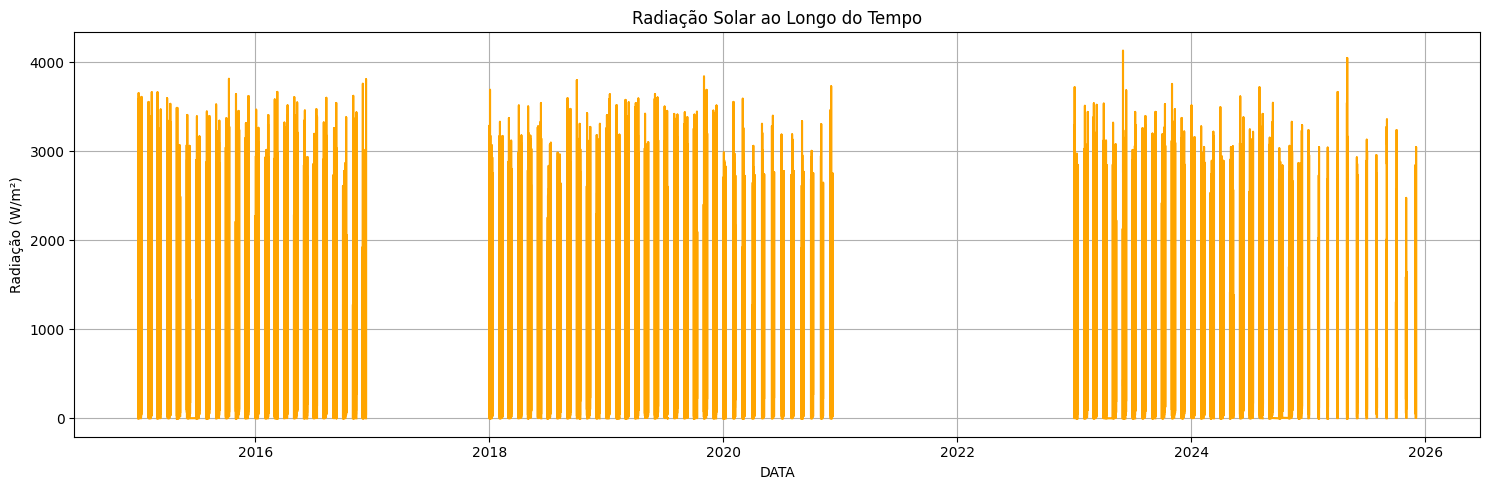

In [95]:
# Gr√°fico de serie temporal
plt.figure(figsize=(15,5))
plt.plot(df_climatotal['DATA'], df_climatotal['RADIACAO'], color='orange')
plt.xlabel('DATA')
plt.ylabel('Radia√ß√£o (W/m¬≤)')
plt.title('Radia√ß√£o Solar ao Longo do Tempo')
plt.grid(True)
plt.tight_layout()
plt.show()



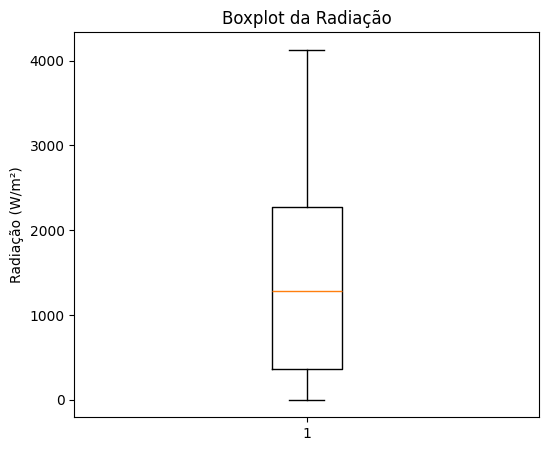

In [83]:
# Boxplot (total)
plt.figure(figsize=(6,5))
plt.boxplot(df_climatotal['RADIACAO'].dropna())
plt.ylabel('Radia√ß√£o (W/m¬≤)')
plt.title('Boxplot da Radia√ß√£o')
plt.show()



<Figure size 1000x600 with 0 Axes>

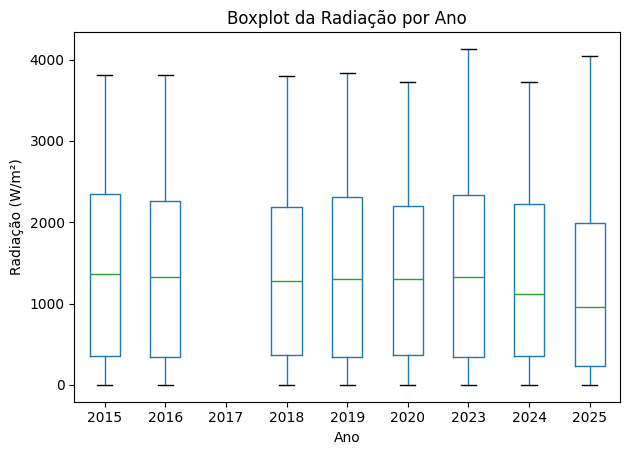

In [84]:
# Boxplot ano a ano
plt.figure(figsize=(10,6))
df_climatotal.boxplot(column='RADIACAO', by='ANO', grid=False)
plt.xlabel('Ano')
plt.ylabel('Radia√ß√£o (W/m¬≤)')
plt.title('Boxplot da Radia√ß√£o por Ano')
plt.suptitle('')
plt.tight_layout()
plt.show()


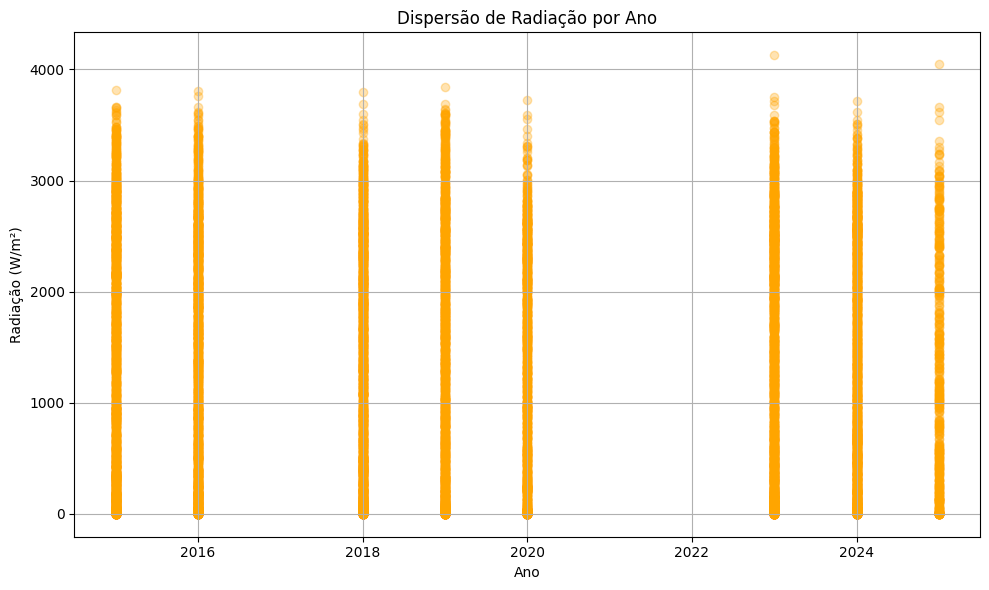

In [85]:
# Gr√°fico de dispers√£o - Radia√ß√£o x Ano
plt.figure(figsize=(10,6))
plt.scatter(df_climatotal['ANO'], df_climatotal['RADIACAO'], alpha=0.3, color='orange')
plt.xlabel('Ano')
plt.ylabel('Radia√ß√£o (W/m¬≤)')
plt.title('Dispers√£o de Radia√ß√£o por Ano')
plt.grid(True)
plt.tight_layout()
plt.show()


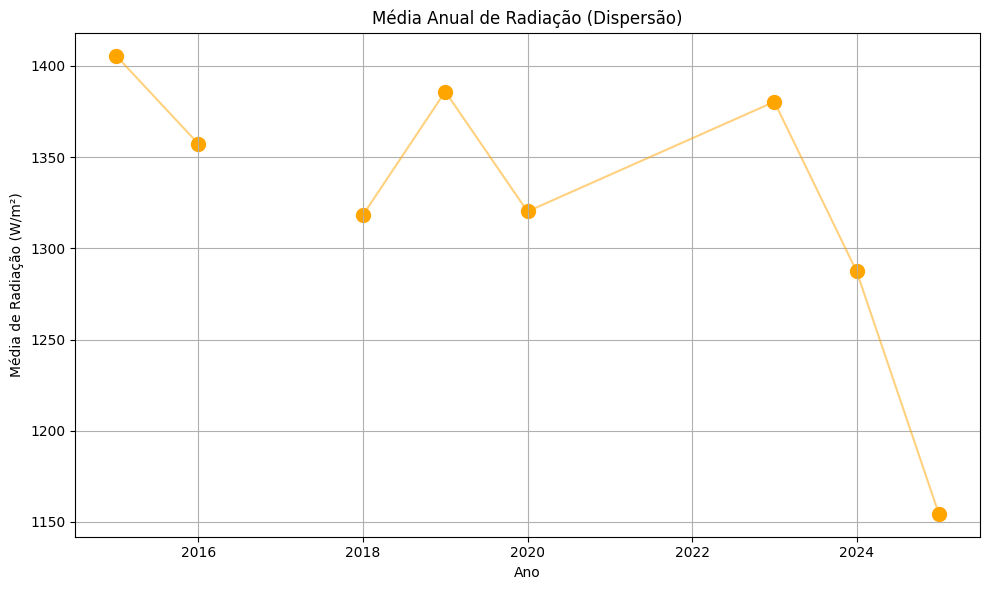

In [86]:
# Dispers√£o - M√©dias anuais
media_ano = df_climatotal.groupby('ANO')['RADIACAO'].mean().reset_index()

plt.figure(figsize=(10,6))
plt.scatter(media_ano['ANO'], media_ano['RADIACAO'], s=100, color='orange')
plt.plot(media_ano['ANO'], media_ano['RADIACAO'], color='orange', alpha=0.5)  # Linha para facilitar tend√™ncia
plt.xlabel('Ano')
plt.ylabel('M√©dia de Radia√ß√£o (W/m¬≤)')
plt.title('M√©dia Anual de Radia√ß√£o (Dispers√£o)')
plt.grid(True)
plt.tight_layout()
plt.show()


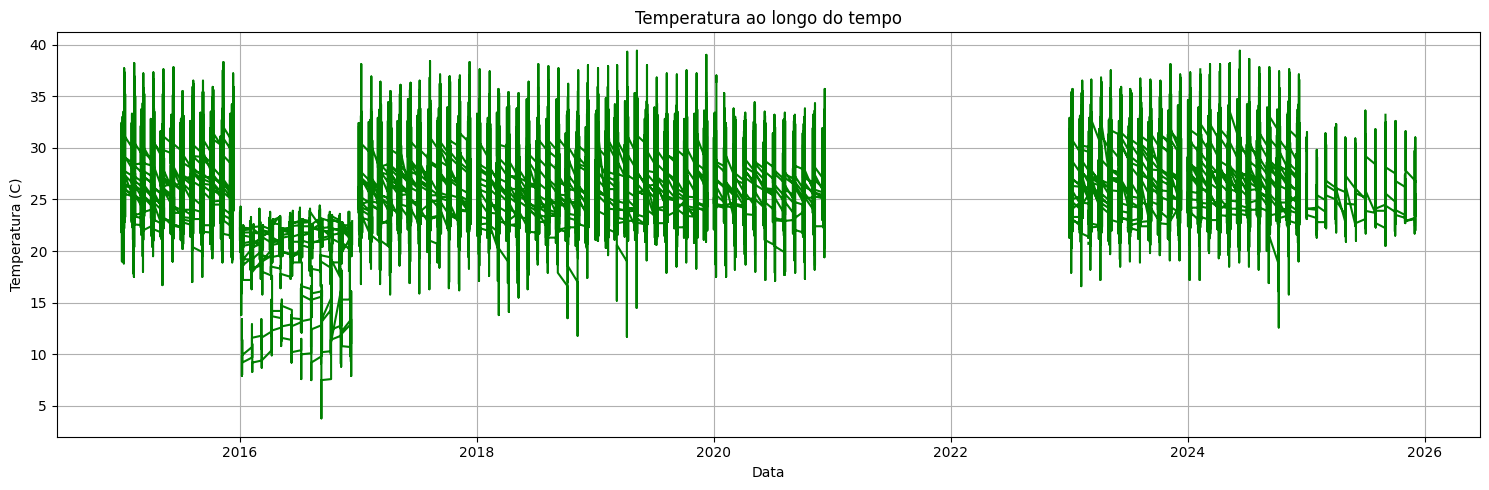

In [87]:
# Gr√°fico de serie temporal
plt.figure(figsize=(15,5))
plt.plot(df_climatotal['DATA'], df_climatotal['TEMPERATURA'], color='green')
plt.xlabel('Data')
plt.ylabel('Temperatura (C)')
plt.title('Temperatura ao longo do tempo')
plt.grid(True)
plt.tight_layout()
plt.show()

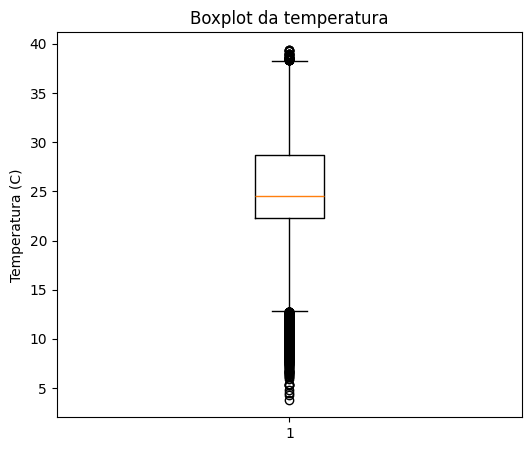

In [52]:
# Boxplot (total)
plt.figure(figsize=(6,5))
plt.boxplot(df_climatotal['TEMPERATURA'].dropna())
plt.ylabel('Temperatura (C)')
plt.title('Boxplot da temperatura')
plt.show()


<Figure size 1000x600 with 0 Axes>

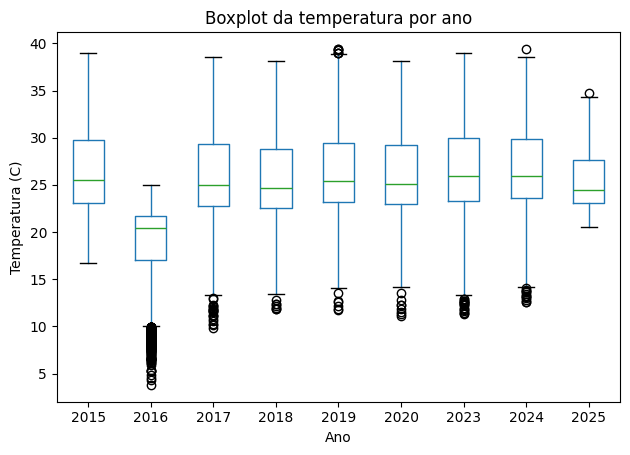

In [54]:
# Boxplot ano a ano
plt.figure(figsize=(10,6))
df_climatotal.boxplot(column='TEMPERATURA', by='ANO', grid=False)
plt.xlabel('Ano')
plt.ylabel('Temperatura (C)')
plt.title('Boxplot da temperatura por ano')
plt.suptitle('')
plt.tight_layout()
plt.show()

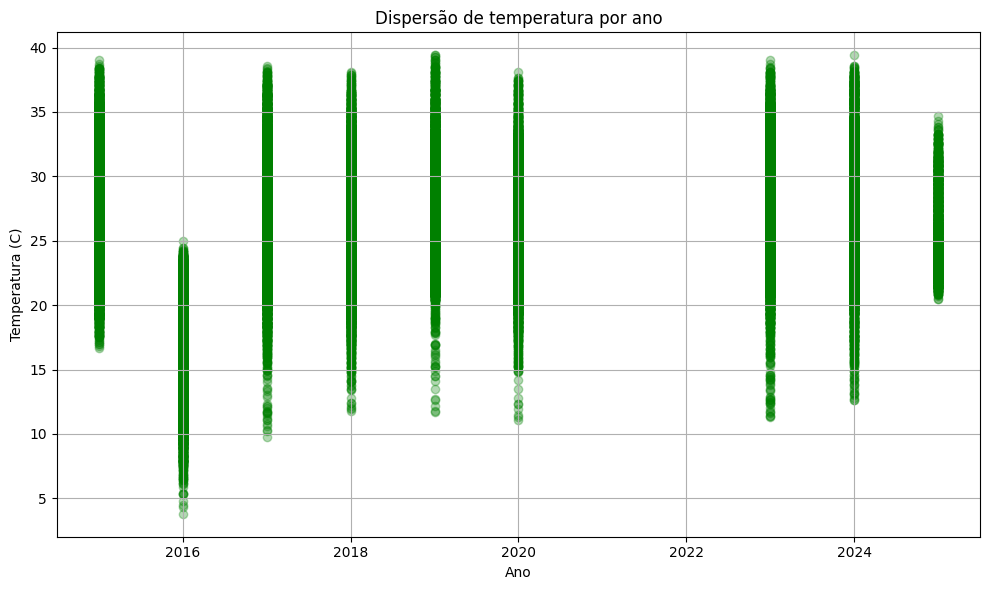

In [56]:
# Gr√°fico de dispers√£o - Radia√ß√£o x Ano
plt.figure(figsize=(10,6))
plt.scatter(df_climatotal['ANO'], df_climatotal['TEMPERATURA'], alpha=0.3, color='green')
plt.xlabel('Ano')
plt.ylabel('Temperatura (C)')
plt.title('Dispers√£o de temperatura por ano')
plt.grid(True)
plt.tight_layout()
plt.show()

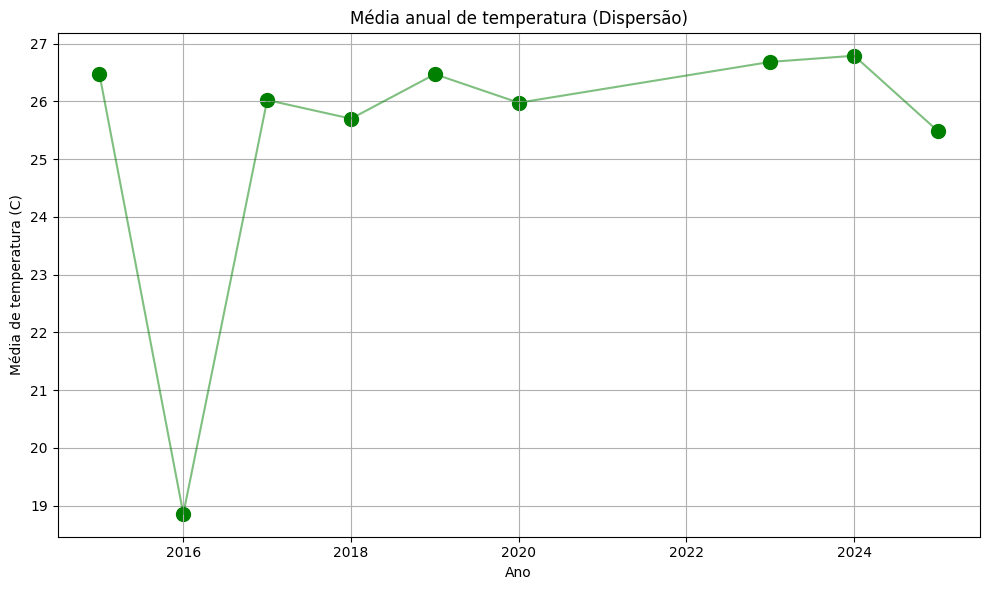

In [59]:
# Dispers√£o - M√©dias anuais
media_ano = df_climatotal.groupby('ANO')['TEMPERATURA'].mean().reset_index()

plt.figure(figsize=(10,6))
plt.scatter(media_ano['ANO'], media_ano['TEMPERATURA'], s=100, color='green')
plt.plot(media_ano['ANO'], media_ano['TEMPERATURA'], color='green', alpha=0.5)  # Linha para facilitar tend√™ncia
plt.xlabel('Ano')
plt.ylabel('M√©dia de temperatura (C)')
plt.title('M√©dia anual de temperatura (Dispers√£o)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [60]:
# Exporta√ß√£o dos dados processados
print("\n5. Exporta√ß√£o dos dados processados")
df_climatotal.to_csv('df_climatotal.csv', index=False)
print("- Dados processados salvos como 'df_climatotal.csv'")


5. Exporta√ß√£o dos dados processados
- Dados processados salvos como 'df_climatotal.csv'


# Produ√ß√£o agr√≠cola üå±üåΩ
Fonte de dados CONAB, s√©rie hist√≥rica gr√£os https://portaldeinformacoes.conab.gov.br/downloads/arquivos/SerieHistoricaGraos.txt

> Adicionar aspas



Bibliotecas necess√°rias

In [96]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import altair as alt

Upload de arquivo

In [97]:
from google.colab import files
uploaded = files.upload()

In [110]:
# Check dos arquivos carregados
df = pd.read_csv("serie_historica_graos.csv", sep=";", encoding='latin1')
print("\nVisualiza√ß√£o correta do arquivo:")
print(df.head())


Visualiza√ß√£o correta do arquivo:
           ano_agricola dsc_safra_previsao  uf  \
0  1976/77                 UNICA            AL   
1  1976/77                 UNICA            BA   
2  1976/77                 UNICA            CE   
3  1976/77                 UNICA            GO   
4  1976/77                 UNICA            MA   

                                    produto  id_produto  area_plantada_mil_ha  \
0  ALGODAO EM PLUMA                                4586                  99.3   
1  ALGODAO EM PLUMA                                4586                 123.4   
2  ALGODAO EM PLUMA                                4586                1296.0   
3  ALGODAO EM PLUMA                                4586                  73.1   
4  ALGODAO EM PLUMA                                4586                  44.4   

   producao_mil_t  produtividade_mil_ha_mil_t  
0             6.0                         0.1  
1             7.0                         0.1  
2            70.0               

Tratamento dos dados


In [99]:
# Filtrar apenas UF = MT (Mato Grosso)
df = df[df['uf'].str.strip().str.upper() == 'MT'].copy()

# Separar o ano_agricola em primeiro_ano e segundo_ano
def separa_anos(ano_agricola):
    if isinstance(ano_agricola, str) and '/' in ano_agricola:
        a1, a2 = ano_agricola.split('/')
        return a1.strip(), a2.strip()
    elif isinstance(ano_agricola, str):
        return ano_agricola.strip(), None
    else:
        return None, None

anos = df['ano_agricola'].apply(separa_anos)
df['primeiro_ano'] = anos.str[0]
df['segundo_ano'] = anos.str[1]

# Renomear colunas
df = df.rename(columns={
    'dsc_safra_previsao': 'safra',
    'area_plantada_mil_ha': 'area_plantada',
    'producao_mil_t': 'producao',
    'produtividade_mil_ha_mil_t': 'produtividade'
})

# Corrigir caracteres na coluna safra
def padroniza_safra(s):
    if not isinstance(s, str): return s
    s = s.upper().strip()
    # Corrige variantes de 1¬™ SAFRA
    s = re.sub(r'1[√ÇA¬™Aa]*\s*SAFRA', '1¬™ SAFRA', s)
    # Corrige variantes de 2¬™ SAFRA
    s = re.sub(r'2[√ÇA¬™Aa]*\s*SAFRA', '2¬™ SAFRA', s)
    # Corrige variantes de 3¬™ SAFRA
    s = re.sub(r'3[√ÇA¬™Aa]*\s*SAFRA', '3¬™ SAFRA', s)
    # Se tiver 'UNICA' transforma em '√öNICA' (opcional)
    s = re.sub(r'UNICA', '√öNICA', s)
    return s.title()

df['safra'] = df['safra'].apply(padroniza_safra)

# Filtrar somente produto MILHO (independente de espa√ßos mai√∫sculas ou acentua√ß√£o)
df = df[df['produto'].str.strip().str.upper() == 'MILHO']

# Selecionar colunas finais na ordem desejada
colunas = [
    'ano_agricola', 'primeiro_ano', 'segundo_ano', 'safra',
    'uf', 'produto', 'area_plantada', 'producao', 'produtividade'
]
df_milho = df[colunas].reset_index(drop=True)

# Remover valores nulos nas colunas principais
df_milho = df_milho.dropna(subset=[
    'ano_agricola', 'primeiro_ano', 'segundo_ano', 'safra',
    'area_plantada', 'producao', 'produtividade'
]).reset_index(drop=True)

# Print para conferir se sobraram nulos
print("\nValores nulos por coluna:")
print(df_milho.isnull().sum())

# Visualiza√ß√£o final
print(f"\nBase consolidada: {df_milho.shape[0]} linhas x {df_milho.shape[1]} colunas.")
print(df_milho.head())
print(f"O DataFrame tem {df_milho.shape[0]} linhas e {df_milho.shape[1]} colunas.")





Valores nulos por coluna:
ano_agricola     0
primeiro_ano     0
segundo_ano      0
safra            0
uf               0
produto          0
area_plantada    0
producao         0
produtividade    0
dtype: int64

Base consolidada: 89 linhas x 9 colunas.
           ano_agricola primeiro_ano segundo_ano     safra  uf  \
0  1976/77                      1976          77  1¬™ Safra  MT   
1  1977/78                      1977          78  1¬™ Safra  MT   
2  1978/79                      1978          79  1¬™ Safra  MT   
3  1979/80                      1979          80  1¬™ Safra  MT   
4  1980/81                      1980          81  1¬™ Safra  MT   

                                    produto  area_plantada  producao  \
0  MILHO                                             247.0     385.0   
1  MILHO                                             179.0     250.0   
2  MILHO                                              76.0     118.0   
3  MILHO                                              86.

Analise explorat√≥ria

In [100]:
print(df_milho.describe())

       area_plantada      producao  produtividade
count      89.000000     89.000000      89.000000
mean     1033.767416   5700.775281       3.961798
std      1846.049375  11889.778998       2.315290
min         0.000000      0.000000       0.000000
25%        85.000000    385.000000       2.100000
50%       220.000000    698.000000       3.700000
75%       704.000000   2456.000000       5.900000
max      7367.300000  50731.200000       8.400000



4. Visualiza√ß√£o de Dados
 Histograma - Distribui√ß√£o das vari√°veis:


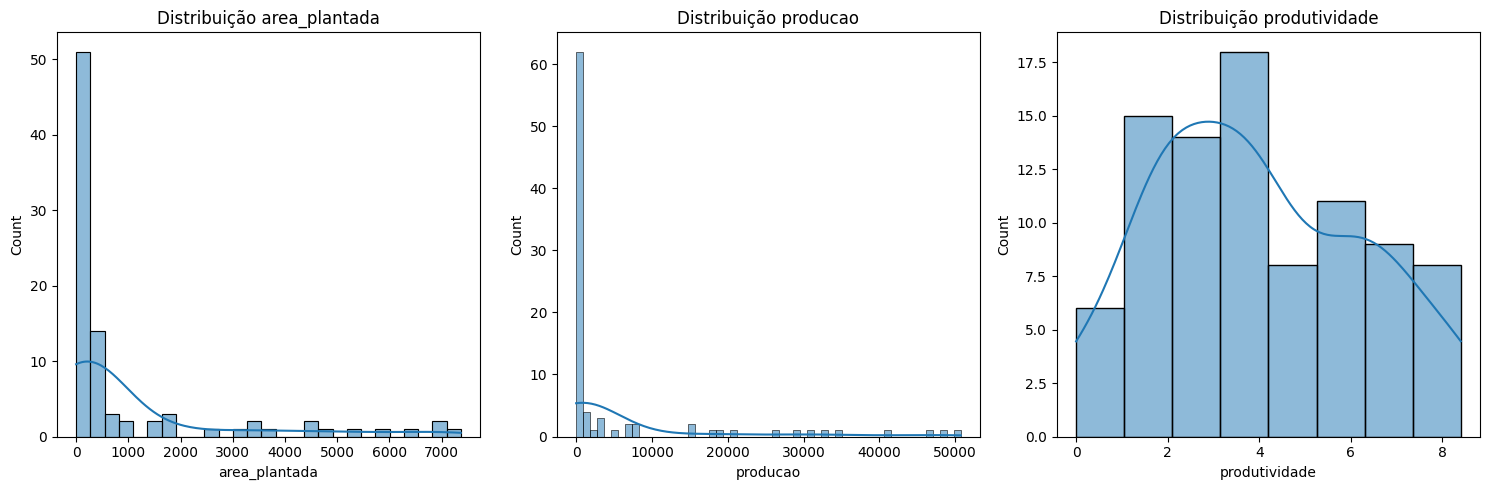

In [101]:
## Visualiza√ß√£o de Dados
print("\n4. Visualiza√ß√£o de Dados")

# Distribui√ß√µes (histogramas)
print(" Histograma - Distribui√ß√£o das vari√°veis:")
plt.figure(figsize=(15, 5))

# Define colunas_numericas aqui
colunas_numericas = ['area_plantada', 'producao', 'produtividade']

for i, coluna in enumerate(colunas_numericas):
    plt.subplot(1, 3, i+1)
    sns.histplot(df_milho[coluna], kde=True)
    plt.title(f'Distribui√ß√£o {coluna}')

plt.tight_layout()
plt.show()


 Evolu√ß√£o temporal das m√©tricas:


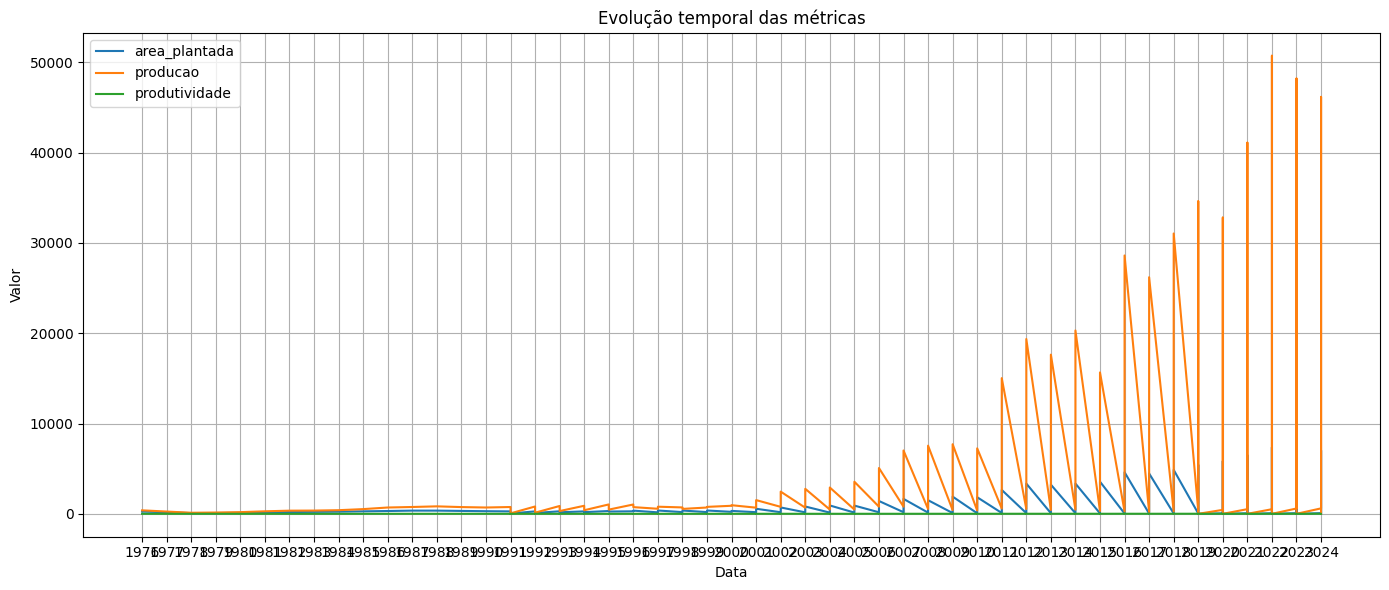

In [102]:
# S√©ries temporais geral
print("\n Evolu√ß√£o temporal das m√©tricas:")
plt.figure(figsize=(14, 6))
for coluna in colunas_numericas:
    plt.plot(df_milho['primeiro_ano'], df_milho[coluna], label=coluna)
plt.title('Evolu√ß√£o temporal das m√©tricas')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


 Evolu√ß√£o temporal das m√©tricas (2015 em diante):
Quantidade de linhas de 2015 em diante: 26


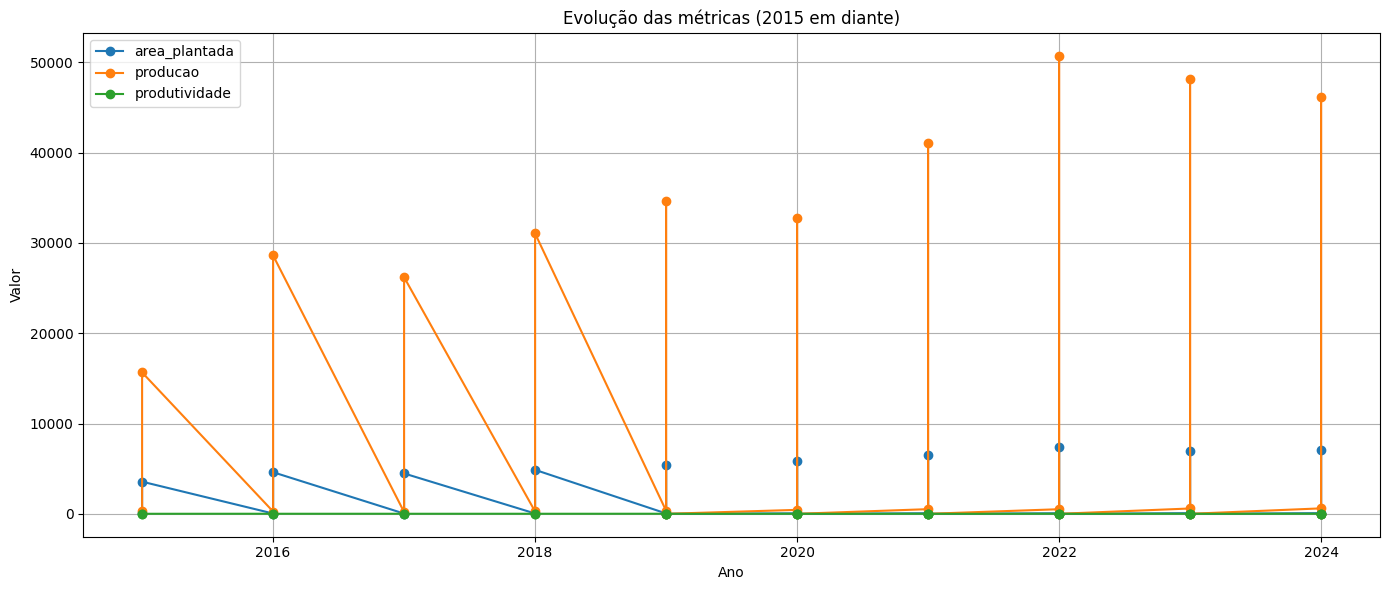

In [103]:
# S√©ries temporais de 2015 em diante
print("\n Evolu√ß√£o temporal das m√©tricas (2015 em diante):")
# Filtra para anos de 2015 para frente

# Converter 'primeiro_ano' para numerio
df_milho['primeiro_ano'] = pd.to_numeric(df_milho['primeiro_ano'], errors='coerce')
df_2015_em_diante = df_milho[df_milho['primeiro_ano'] >= 2015].copy()

print(f"Quantidade de linhas de 2015 em diante: {df_2015_em_diante.shape[0]}")

plt.figure(figsize=(14, 6))
for coluna in colunas_numericas:
    plt.plot(df_2015_em_diante['primeiro_ano'], df_2015_em_diante[coluna], marker='o', label=coluna)
plt.title('Evolu√ß√£o das m√©tricas (2015 em diante)')
plt.xlabel('Ano')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


 Boxplots - Compara√ß√£o de distribui√ß√£o entre vari√°veis (escalas separadas):


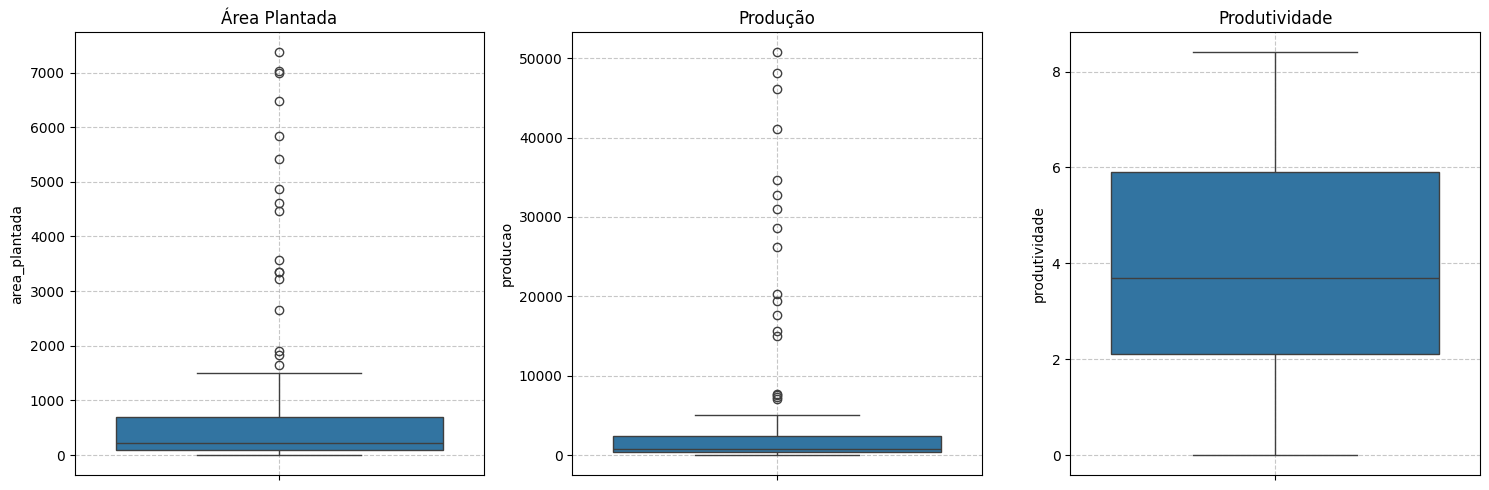


 Boxplots - Distribui√ß√£o normalizada para compara√ß√£o entre vari√°veis:


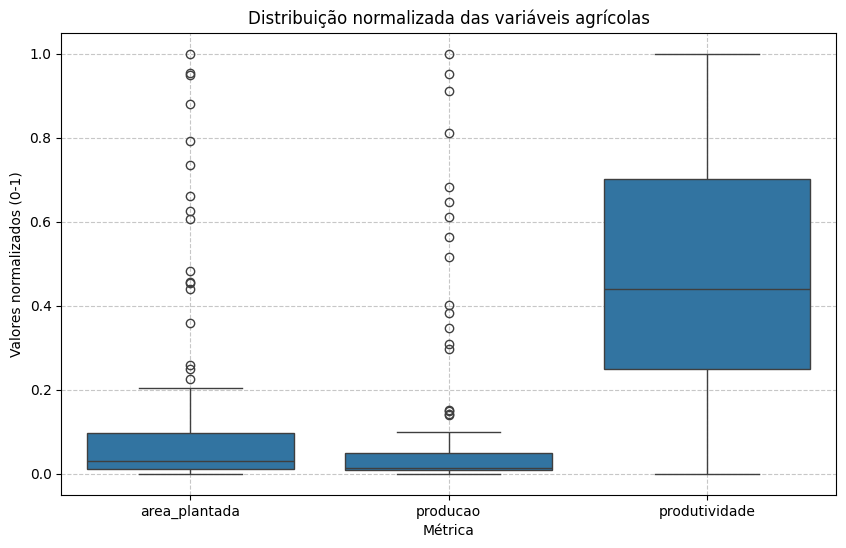

In [104]:
# Compara√ß√£o de vari√°veis (boxplots)
# Definir as vari√°veis num√©ricas de interesse
colunas_numericas = ['area_plantada', 'producao', 'produtividade']

# Boxplots em escalas separadas
print("\n Boxplots - Compara√ß√£o de distribui√ß√£o entre vari√°veis (escalas separadas):")
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(y=df_milho['area_plantada'])
plt.title('√Årea Plantada')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 3, 2)
sns.boxplot(y=df_milho['producao'])
plt.title('Produ√ß√£o')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 3, 3)
sns.boxplot(y=df_milho['produtividade'])
plt.title('Produtividade')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Boxplots normalizados para compara√ß√£o direta
print("\n Boxplots - Distribui√ß√£o normalizada para compara√ß√£o entre vari√°veis:")
plt.figure(figsize=(10, 6))

# Criar DataFrame para visualiza√ß√£o
df_melt = df_milho.melt(id_vars='primeiro_ano', value_vars=colunas_numericas,
                  var_name='M√©trica', value_name='Valor')

# Adicionar vers√£o normalizada das vari√°veis
df_norm = df_milho.copy()
for coluna in colunas_numericas:
    df_norm[coluna] = (df_milho[coluna] - df_milho[coluna].min()) / (df_milho[coluna].max() - df_milho[coluna].min())

df_melt_norm = df_norm.melt(id_vars='primeiro_ano', value_vars=colunas_numericas,
                  var_name='M√©trica', value_name='Valor Normalizado')

sns.boxplot(x='M√©trica', y='Valor Normalizado', data=df_melt_norm)
plt.title('Distribui√ß√£o normalizada das vari√°veis agr√≠colas')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylabel('Valores normalizados (0-1)')
plt.show()



 Dispers√£o - Rela√ß√µes entre vari√°veis:


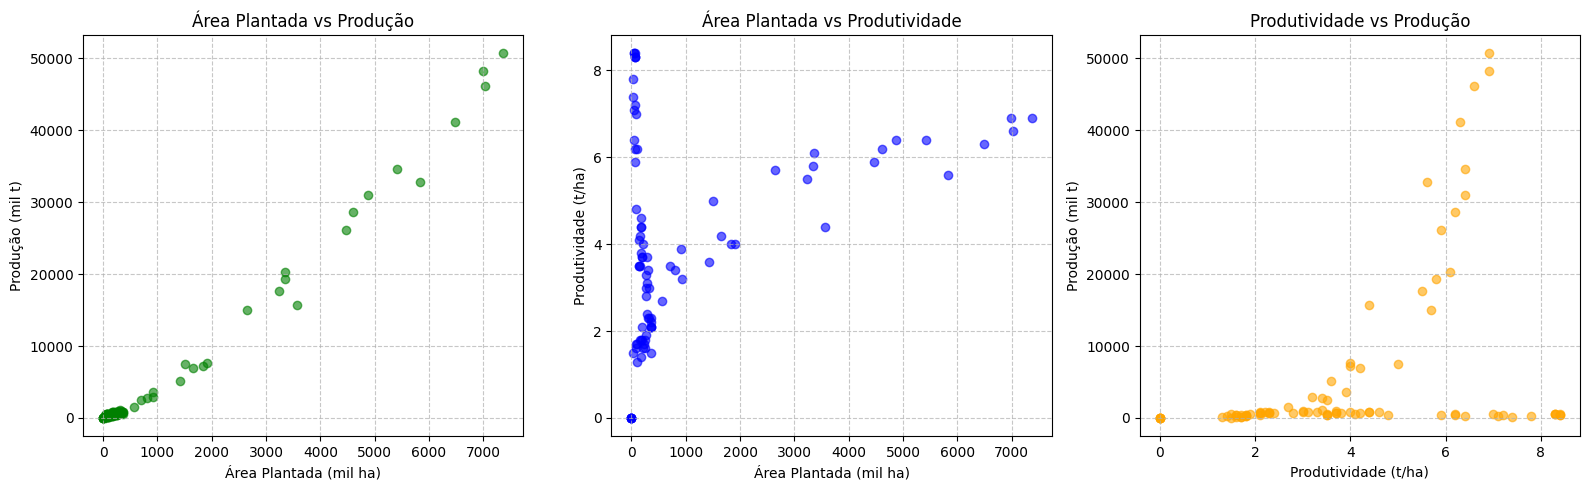

In [105]:
# Rela√ß√µes entre vari√°veis (dispers√£o)
print("\n Dispers√£o - Rela√ß√µes entre vari√°veis:")
plt.figure(figsize=(16, 5))

# Gr√°fico 1: √Årea Plantada vs Produ√ß√£o
plt.subplot(1, 3, 1)
plt.scatter(df_milho['area_plantada'], df_milho['producao'], alpha=0.6, color='green')
plt.title('√Årea Plantada vs Produ√ß√£o')
plt.xlabel('√Årea Plantada (mil ha)')
plt.ylabel('Produ√ß√£o (mil t)')
plt.grid(True, linestyle='--', alpha=0.7)

# Gr√°fico 2: √Årea Plantada vs Produtividade
plt.subplot(1, 3, 2)
plt.scatter(df_milho['area_plantada'], df_milho['produtividade'], alpha=0.6, color='blue')
plt.title('√Årea Plantada vs Produtividade')
plt.xlabel('√Årea Plantada (mil ha)')
plt.ylabel('Produtividade (t/ha)')
plt.grid(True, linestyle='--', alpha=0.7)

# Gr√°fico 3: Produtividade vs Produ√ß√£o
plt.subplot(1, 3, 3)
plt.scatter(df_milho['produtividade'], df_milho['producao'], alpha=0.6, color='orange')
plt.title('Produtividade vs Produ√ß√£o')
plt.xlabel('Produtividade (t/ha)')
plt.ylabel('Produ√ß√£o (mil t)')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



 Boxplots - Evolu√ß√£o por safra:


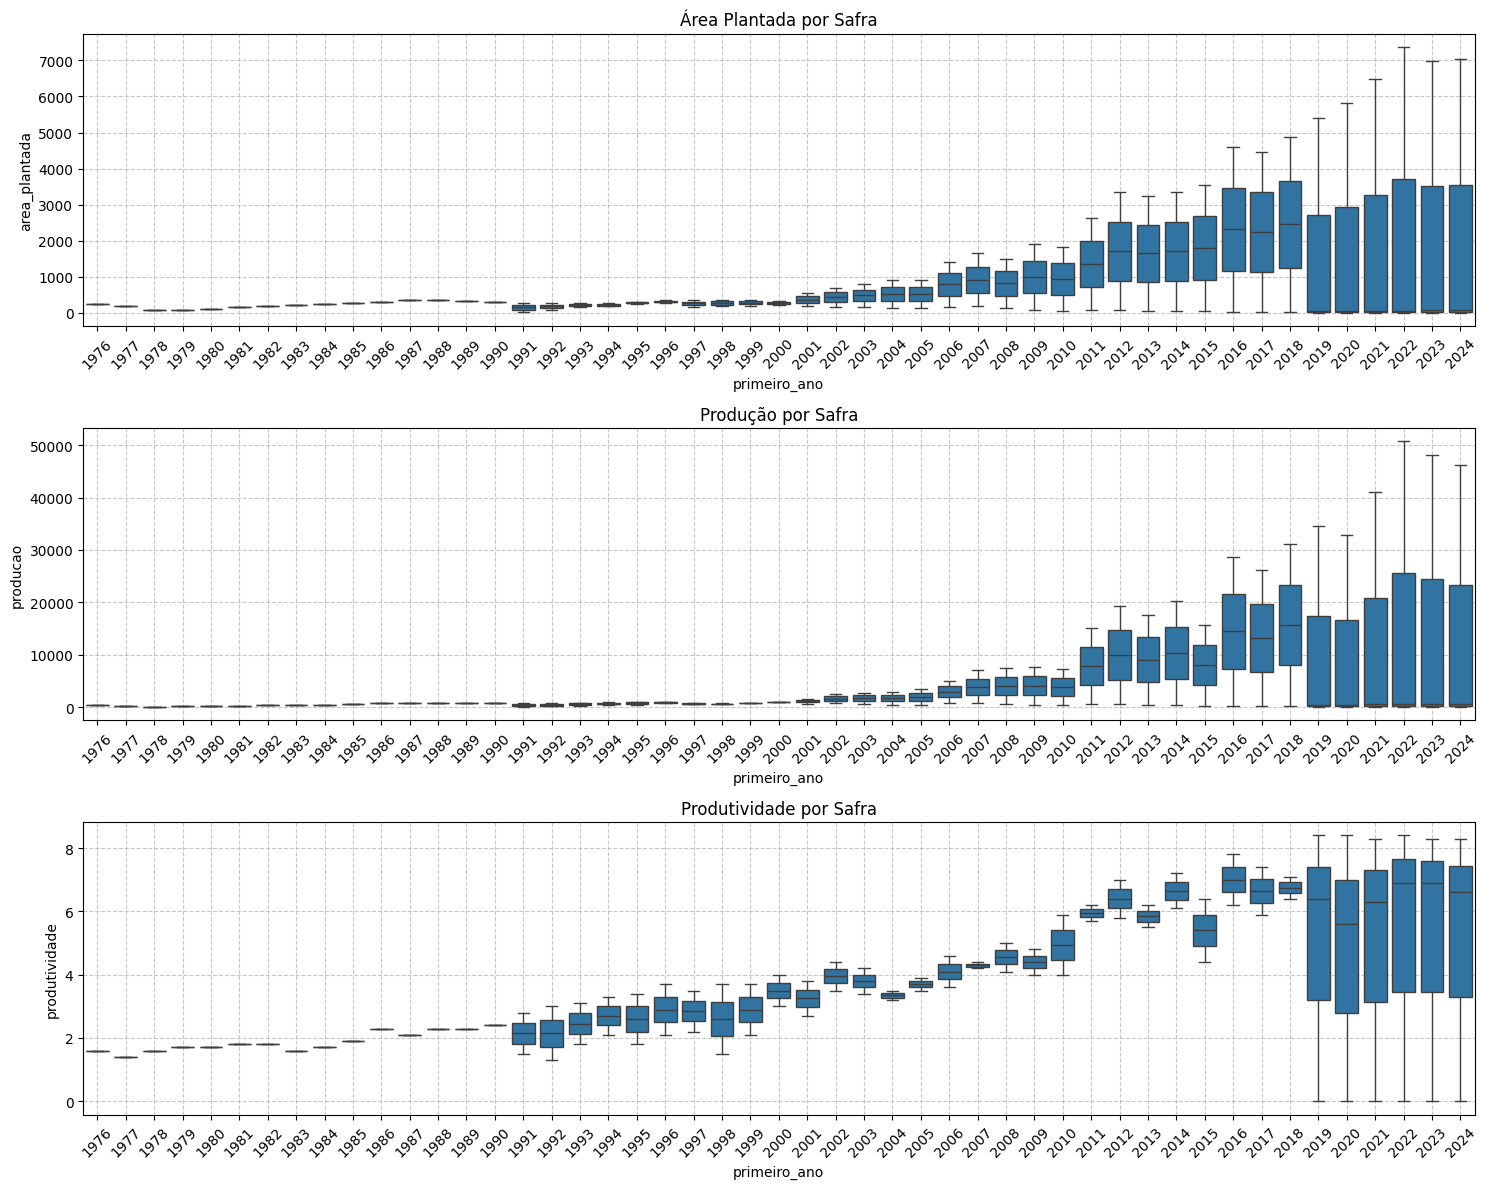

In [106]:
# Boxplots agrupados por safra
print("\n Boxplots - Evolu√ß√£o por safra:")
plt.figure(figsize=(15, 12))

plt.subplot(3, 1, 1)
sns.boxplot(x='primeiro_ano', y='area_plantada', data=df_milho)
plt.title('√Årea Plantada por Safra')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.subplot(3, 1, 2)
sns.boxplot(x='primeiro_ano', y='producao', data=df_milho)
plt.title('Produ√ß√£o por Safra')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.subplot(3, 1, 3)
sns.boxplot(x='primeiro_ano', y='produtividade', data=df_milho)
plt.title('Produtividade por Safra')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


 Matriz de correla√ß√£o entre as m√©tricas:


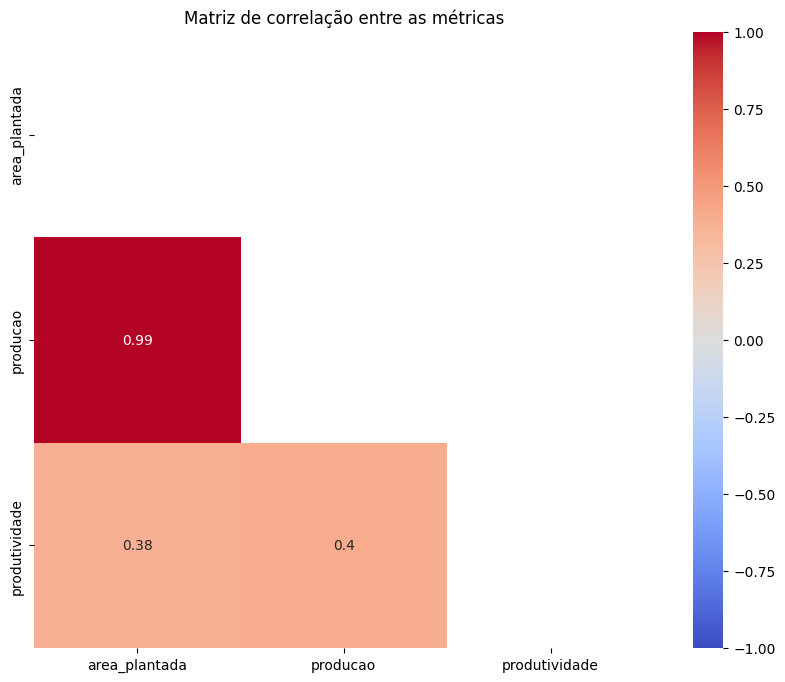

In [107]:
# Matriz de correla√ß√£o
print("\n Matriz de correla√ß√£o entre as m√©tricas:")
plt.figure(figsize=(10, 8))
corr = df_milho[colunas_numericas].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, cmap='coolwarm', mask=mask, vmin=-1, vmax=1)
plt.title('Matriz de correla√ß√£o entre as m√©tricas')
plt.show()

In [108]:
# Visualiza√ß√µes interativas com Altair
print("\n Visualiza√ß√£o interativa de s√©ries temporais:")

# Criar gr√°fico interativo para cada m√©trica
charts = []
for coluna in colunas_numericas:
    chart = alt.Chart(df_milho).mark_line().encode(
        x='primeiro_ano',
        y=alt.Y(coluna, title=coluna),
        tooltip=['primeiro_ano', coluna]
    ).properties(
        title=f'S√©rie Temporal - {coluna}',
        width=300,
        height=200
    )
    charts.append(chart)

# Exibir gr√°ficos em grid
display(alt.vconcat(*charts))


 Visualiza√ß√£o interativa de s√©ries temporais:


alt.VConcatChart(...)

In [109]:
## 5. Exporta√ß√£o/Salvamento dos Dados Processados
print("\n5. Exporta√ß√£o dos Dados Processados")
df_milho.to_csv('milho.csv', index=False)
print("\n Dados filtrados salvos como 'milho.csv'")


5. Exporta√ß√£o dos Dados Processados

 Dados filtrados salvos como 'milho.csv'


# Etapa 2 ‚Äì Extra√ß√£o de Informa√ß√µes Relevantes:

*   Definir vari√°veis-chave a serem utilizadas no modelo, a partir da an√°lise
explorat√≥ria dos dados.
*   Analisar a rela√ß√£o entre NDVI e produtividade agr√≠cola, identificando os per√≠odos cr√≠ticos de crescimento da cultura.
*   Aplicar t√©cnicas de segmenta√ß√£o para destacar √°reas espec√≠ficas de cultivo na imagem de sat√©lite.

Montando o dataset unico

Definimos utilizar as variaveis abaixo pois apresentaram melhor... TERMINAR DE PREENCHER

In [171]:
print (df_satveg.head())
#print (df_climatotal.head())

        Data    NDVI  PreFiltro  FlatBottom   AnoMes  NDVI_media_mensal  mes  \
0 2000-02-18  0.6119     0.6542      0.6542  2000-02            0.61190    2   
1 2000-03-05  0.6542     0.6542      0.6542  2000-03            0.61465    3   
2 2000-03-21  0.5751     0.5751      0.6542  2000-03            0.61465    3   
3 2000-04-06  0.6839     0.6839      0.6839  2000-04            0.58180    4   
4 2000-04-22  0.4797     0.4797      0.4808  2000-04            0.58180    4   

    ano  
0  2000  
1  2000  
2  2000  
3  2000  
4  2000  


In [168]:
# Padroniza√ß√£o dos nomes das colunas
df_satveg.columns = df_satveg.columns.str.strip()
df_climatotal.columns = df_climatotal.columns.str.strip()
df_milho.columns = df_milho.columns.str.strip()



In [174]:
# Gerar NDVI m√©dio anual
# Calcular NDVI m√©dio anual
ndvi_medio_ano = (
    df_satveg.groupby('ano')['NDVI_media_mensal']
    .mean()
    .reset_index()
    .rename(columns={'NDVI_media_mensal': 'ndvi_medio_ano'})
)
print(ndvi_medio_ano.head())

    ano  ndvi_medio_ano
0  2000        0.394245
1  2001        0.453787
2  2002        0.473991
3  2003        0.496161
4  2004        0.441365


In [179]:
print(df_climatotal.head())
print(df_climatotal.dtypes)

        DATA   HORA  RADIACAO  TEMPERATURA  ANO_MES   ANO  MES
0 2015-01-01  00:00       NaN         23.0  2015-01  2015    1
1 2015-01-01  01:00       NaN         23.1  2015-01  2015    1
2 2015-01-01  02:00       NaN         22.9  2015-01  2015    1
3 2015-01-01  03:00       NaN         22.7  2015-01  2015    1
4 2015-01-01  04:00       NaN         22.4  2015-01  2015    1
DATA           datetime64[ns]
HORA                   object
RADIACAO              float64
TEMPERATURA           float64
ANO_MES                object
ANO                     Int64
MES                     Int64
dtype: object


In [181]:
# Garantir tipos no clima e milho
# Tratando NA ou NaN antes
df_climatotal['ANO'] = pd.to_numeric(df_climatotal['ANO'], errors='coerce').astype('Int64')
df_milho['primeiro_ano'] = df_milho['primeiro_ano'].astype(int)
ndvi_medio_ano['ano'] = ndvi_medio_ano['ano'].astype(int)

print(df_climatotal.head())
print(df_milho.head())
print(ndvi_medio_ano.head())




        DATA   HORA  RADIACAO  TEMPERATURA  ANO_MES   ANO  MES
0 2015-01-01  00:00       NaN         23.0  2015-01  2015    1
1 2015-01-01  01:00       NaN         23.1  2015-01  2015    1
2 2015-01-01  02:00       NaN         22.9  2015-01  2015    1
3 2015-01-01  03:00       NaN         22.7  2015-01  2015    1
4 2015-01-01  04:00       NaN         22.4  2015-01  2015    1
           ano_agricola  primeiro_ano segundo_ano     safra  uf  \
0  1976/77                       1976          77  1¬™ Safra  MT   
1  1977/78                       1977          78  1¬™ Safra  MT   
2  1978/79                       1978          79  1¬™ Safra  MT   
3  1979/80                       1979          80  1¬™ Safra  MT   
4  1980/81                       1980          81  1¬™ Safra  MT   

                                    produto  area_plantada  producao  \
0  MILHO                                             247.0     385.0   
1  MILHO                                             179.0     250.0  

In [183]:
# Filtrar anos a partir de 2015
anos_validos = set(
    df_milho[df_milho['primeiro_ano'] >= 2015]['primeiro_ano']
) & set(ndvi_medio_ano[ndvi_medio_ano['ano'] >= 2015]['ano']) & set(df_climatotal[df_climatotal['ANO'] >= 2015]['ANO'])

print(anos_validos)

milho_2015 = df_milho[df_milho['primeiro_ano'] >= 2015].copy()
ndvi_2015 = ndvi_medio_ano[ndvi_medio_ano['ano'] >= 2015].copy()
clima_2015 = df_climatotal[df_climatotal['ANO'] >= 2015].copy()


{np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2023), np.int64(2024), np.int64(2015)}


In [186]:
# Merges
# Merge Milho + NDVI anual
base = milho_2015.merge(ndvi_2015, left_on='primeiro_ano', right_on='ano', how='left')
#print(base.head())

#Merge resultado e clima
base = base.merge(clima_2015, left_on='primeiro_ano', right_on='ANO', how='left')
print(base.head())


           ano_agricola  primeiro_ano segundo_ano     safra  uf  \
0  2015/16                       2015          16  1¬™ Safra  MT   
1  2015/16                       2015          16  1¬™ Safra  MT   
2  2015/16                       2015          16  1¬™ Safra  MT   
3  2015/16                       2015          16  1¬™ Safra  MT   
4  2015/16                       2015          16  1¬™ Safra  MT   

                                    produto  area_plantada  producao  \
0  MILHO                                              48.0     307.0   
1  MILHO                                              48.0     307.0   
2  MILHO                                              48.0     307.0   
3  MILHO                                              48.0     307.0   
4  MILHO                                              48.0     307.0   

   produtividade   ano  ndvi_medio_ano       DATA   HORA  RADIACAO  \
0            6.4  2015        0.390774 2015-01-01  00:00       NaN   
1            6.4  2

In [190]:
# Interpola√ß√£o de clima

base = base.sort_values('primeiro_ano').reset_index(drop=True)

# # Criar as colunas 'temp_media_ciclo' e 'rad_media_ciclo' se n√£o existirem, preenchendo com NaN

if 'temp_media_ciclo' not in base.columns:
    base['temp_media_ciclo'] = np.nan
if 'rad_media_ciclo' not in base.columns:
    base['rad_media_ciclo'] = np.nan

# Flags de imputa√ß√£o para analisar depois quais foram preenchidos
base['imputado_temp'] = base['temp_media_ciclo'].isnull()
base['imputado_rad'] = base['rad_media_ciclo'].isnull()

# Interpola√ß√£o linear
base['temp_media_ciclo'] = base['temp_media_ciclo'].interpolate(method='linear', limit_direction='both')
base['rad_media_ciclo']  = base['rad_media_ciclo'].interpolate(method='linear', limit_direction='both')


In [192]:
# Validando resultados
print(base[['primeiro_ano', 'produtividade', 'ndvi_medio_ano',
            'temp_media_ciclo', 'rad_media_ciclo',
            'imputado_temp', 'imputado_rad']])


       primeiro_ano  produtividade  ndvi_medio_ano  temp_media_ciclo  \
0              2015            6.4        0.390774               NaN   
1              2015            6.4        0.390774               NaN   
2              2015            6.4        0.390774               NaN   
3              2015            6.4        0.390774               NaN   
4              2015            6.4        0.390774               NaN   
...             ...            ...             ...               ...   
69121          2024            8.3        0.445917               NaN   
69122          2024            8.3        0.445917               NaN   
69123          2024            8.3        0.445917               NaN   
69124          2024            8.3        0.445917               NaN   
69125          2024            8.3        0.445917               NaN   

       rad_media_ciclo  imputado_temp  imputado_rad  
0                  NaN           True          True  
1                  NaN     

In [194]:
# Exporta√ß√£o dos dados processados
print("\n5. Exporta√ß√£o dos dados processados")
base.to_csv('base.csv', index=False)
print("- Dados processados salvos como 'base.csv'")


5. Exporta√ß√£o dos dados processados
- Dados processados salvos como 'base.csv'


Analisar a rela√ß√£o entre NDVI e produtividade agr√≠cola, identificando os per√≠odos cr√≠ticos de crescimento da cultura.


In [196]:
# Biblioteca necess√°rias
import pandas as pd
import matplotlib.pyplot as plt


In [195]:
# Upload do arquivo
base = pd.read_csv('base.csv')
print(base.head())


           ano_agricola  primeiro_ano  segundo_ano     safra  uf  \
0  2015/16                       2015           16  1¬™ Safra  MT   
1  2015/16                       2015           16  1¬™ Safra  MT   
2  2015/16                       2015           16  1¬™ Safra  MT   
3  2015/16                       2015           16  1¬™ Safra  MT   
4  2015/16                       2015           16  1¬™ Safra  MT   

                                    produto  area_plantada  producao  \
0  MILHO                                              48.0     307.0   
1  MILHO                                              48.0     307.0   
2  MILHO                                              48.0     307.0   
3  MILHO                                              48.0     307.0   
4  MILHO                                              48.0     307.0   

   produtividade   ano  ...   HORA RADIACAO TEMPERATURA  ANO_MES     ANO  MES  \
0            6.4  2015  ...  05:00      NaN        21.9  2015-05  2015.0

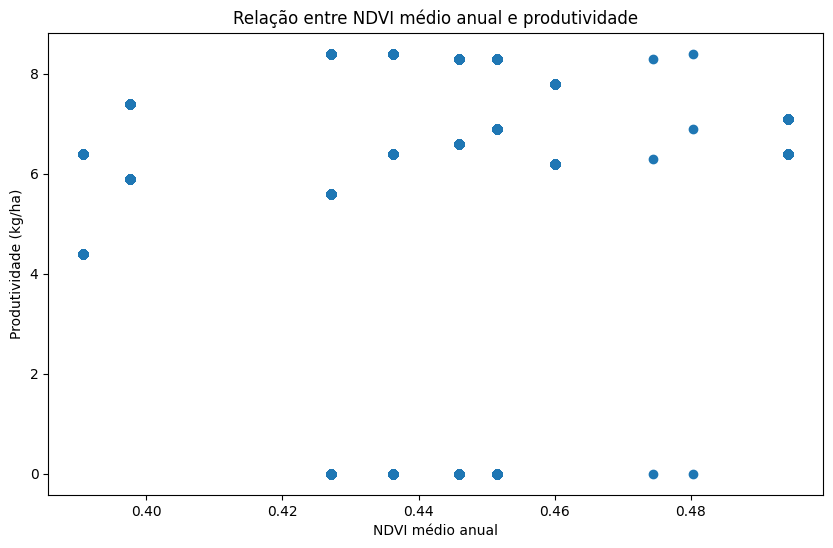

Correla√ß√£o entre NDVI m√©dio anual e produtividade: 0.07


In [197]:
# Avaliar rela√ß√£o NDVI X produtividade (correla√ß√£o)
plt.figure(figsize=(10, 6))
plt.scatter(base['ndvi_medio_ano'], base['produtividade'])
plt.xlabel('NDVI m√©dio anual')
plt.ylabel('Produtividade (kg/ha)')
plt.title('Rela√ß√£o entre NDVI m√©dio anual e produtividade')
plt.show()

cor = base['ndvi_medio_ano'].corr(base['produtividade'])
print(f'Correla√ß√£o entre NDVI m√©dio anual e produtividade: {cor:.2f}')


- Correla√ß√£o de NDVI mensal com produtividade -
ndvi_mes_01    0.218119
ndvi_mes_12    0.147803
ndvi_mes_10    0.100523
ndvi_mes_02    0.053463
ndvi_mes_04    0.024682
ndvi_mes_05   -0.010136
ndvi_mes_09   -0.019967
ndvi_mes_08   -0.042537
ndvi_mes_11   -0.086832
ndvi_mes_06   -0.105774
ndvi_mes_03   -0.139467
ndvi_mes_07   -0.154484
dtype: float64


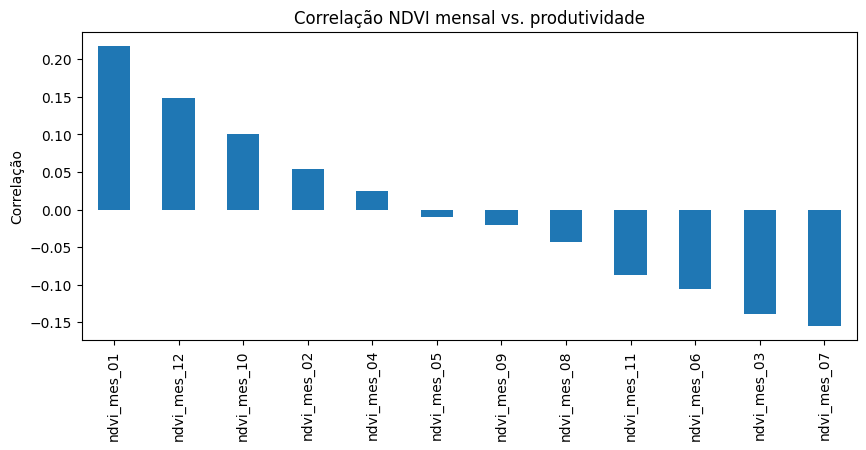


Jan apresentou a maior correla√ß√£o.

Sugerindo que esse per√≠odo √© especialmente cr√≠tico para o sucesso produtivo da cultura analisada.


In [207]:
# An√°lise de periodos criticos  (com NDVI mensal por ano)

# Criar tabela de NDVI mensal (pivoteamento)
tabela = df_satveg[df_satveg['ano'] >= 2015].pivot_table(index='ano', columns='mes', values='NDVI_media_mensal', aggfunc='mean')
tabela.columns = [f'ndvi_mes_{m:02d}' for m in tabela.columns]
tabela.reset_index(inplace=True)

# Juntar com produtividade
prod = base[['primeiro_ano', 'produtividade']].rename(columns={'primeiro_ano':'ano'})
analise = prod.merge(tabela, on='ano', how='left')

# Calcular correla√ß√£o de NDVI de cada m√™s X produtividade
correlacoes = {}
for col in analise.columns:
    if col.startswith('ndvi_mes_'):
        correlacoes[col] = analise[col].corr(analise['produtividade'])

correlacoes = pd.Series(correlacoes).sort_values(ascending=False)
print('- Correla√ß√£o de NDVI mensal com produtividade -')
print(correlacoes)

# Visualizar
correlacoes.plot(kind='bar', figsize=(10,4), title='Correla√ß√£o NDVI mensal vs. produtividade')
plt.ylabel('Correla√ß√£o')
plt.show()

plt.show()
print("\nJan apresentou a maior correla√ß√£o.\n")
print("Sugerindo que esse per√≠odo √© especialmente cr√≠tico para o sucesso produtivo da cultura analisada.")


- Correla√ß√£o das janelas de NDVI com a produtividade -
janela_01_03    0.164588
janela_08_10    0.061626
janela_10_12    0.057410
janela_09_11   -0.017435
janela_04_06   -0.033528
janela_02_04   -0.055386
janela_03_05   -0.061134
janela_05_07   -0.086112
janela_07_09   -0.102466
janela_06_08   -0.125747
dtype: float64


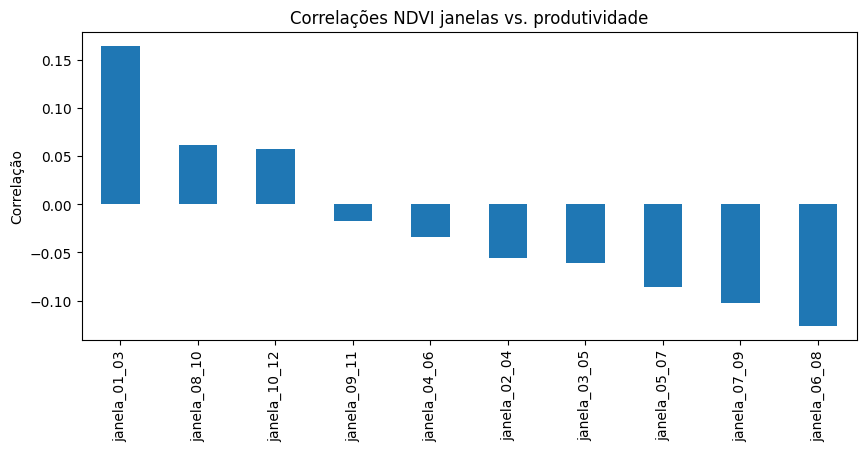


Jan/Mar apresentou a maior correla√ß√£o.

Conclus√£o: Vigor da vegeta√ß√£o no in√≠cio do ciclo √© determinante para produtividade.


In [205]:
# Janelas m√≥veis de NDVI m√©dio
for mes_inicio in range(1, 11):
    colunas = [f'ndvi_mes_{mes_inicio:02d}', f'ndvi_mes_{mes_inicio+1:02d}', f'ndvi_mes_{mes_inicio+2:02d}']
    if all(col in analise.columns for col in colunas):
        analise[f'janela_{mes_inicio:02d}_{mes_inicio+2:02d}'] = analise[colunas].mean(axis=1)

# Repetir a an√°lise de correla√ß√£o para as novas colunas
cor_janelas = {col: analise[col].corr(analise['produtividade'])
               for col in analise.columns if col.startswith('janela_')}
cor_janelas = pd.Series(cor_janelas).sort_values(ascending=False)
print('- Correla√ß√£o das janelas de NDVI com a produtividade -')
print(cor_janelas)

cor_janelas.plot(kind='bar', figsize=(10,4), title='Correla√ß√µes NDVI janelas vs. produtividade')
plt.ylabel('Correla√ß√£o')
plt.show()

plt.show()
print("\nJan/Mar apresentou a maior correla√ß√£o.\n")
print("Conclus√£o: Vigor da vegeta√ß√£o no in√≠cio do ciclo √© determinante para produtividade.")

